In [1]:
import os, sys
from matplotlib import pyplot as plt
import numpy as np
import rasterio as rio
from shapely.geometry import Polygon
from rasterio.mask import mask



In [2]:
## specify the rasters to use for ROC analysis
im_UNet_RGB1 = 'denver_2m_IS_UNet_BGR.tif'
im_UNet_RGB2 = 'denver_2m_IS_UNet_BGR_e100_b32.tif'
im_UNet_4band = 'denver_2m_IS_UNet_stats_MS_4band_bgrn_e100_b8_train.tif'
im_UNet_8band = 'denver_2m_IS_UNet_stats_MS_8band_e100_b8_train.tif'
dg_LULC = '../gbdx_outputs/LULC/055530875010_01_assembly_EXT_NEL_LULC.tif'
dg_BUE = '../gbdx_outputs/BUextent/055530875010_01_assembly_EXT_BEX_PANTEX10.tif'
gt_2m = '../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0_wgs84.tif'

# open one of the UNet results
with rio.open(im_UNet_RGB1, 'r') as src:
    arr = src.read(1)
    bnds = src.bounds
    tf = src.transform

proc_aoi = Polygon([[bnds.left, bnds.bottom],
         [bnds.right, bnds.bottom],
         [bnds.right, bnds.top], 
         [bnds.left, bnds.top],
         [bnds.left, bnds.bottom]])

# open ground truth array    
with rio.open(gt_2m, 'r') as src:
    gt_arr,_ = mask(src, [proc_aoi.__geo_interface__], crop=True, all_touched=True)
    
## make no data pixels == 0
gt_arr[gt_arr==3] = 0
    


C:\anaconda3\envs\earth-analytics-python\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## open the DG results
    
with rio.open(dg_BUE) as src:

    dg_bue_arr, ntf = mask(src, [proc_aoi.__geo_interface__], crop=True, all_touched=True)
    print(dg_bue_arr.shape)
    
with rio.open(dg_LULC) as src:

    dg_lulc_arr, ntf = mask(src, [proc_aoi.__geo_interface__], crop=True, all_touched=True)
    print(dg_lulc_arr.shape)
    



(1, 2043, 2043)
(3, 2043, 2043)


In [4]:
lulc_arr = np.sum(dg_lulc_arr, axis=0)
manmade = np.zeros(lulc_arr.shape)
manmade[lulc_arr == 384] = 1

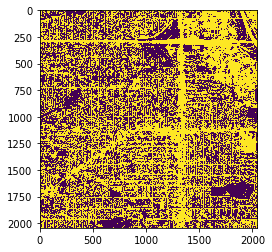

In [5]:
plt.imshow(manmade);

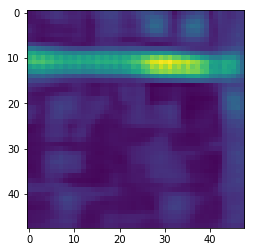

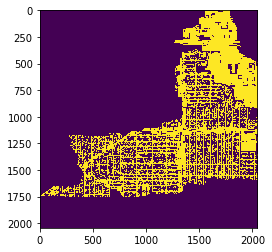

In [6]:
## check a window
wmin = 2000
wmax = wmin+64
a = manmade[wmin:wmax, wmin:wmax]
a = arr[wmin:wmax, wmin:wmax]
b = gt_arr[0, wmin:wmax, wmin:wmax]
plt.imshow(a)
plt.show()
plt.imshow(gt_arr[0])

## iterate through the ground truth raster and process a window which has more than 80% impervious cover

## iterate over the UNet results

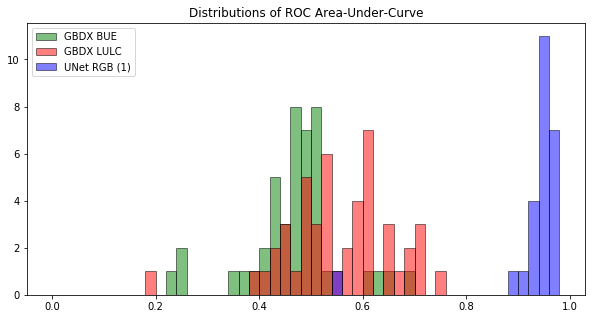

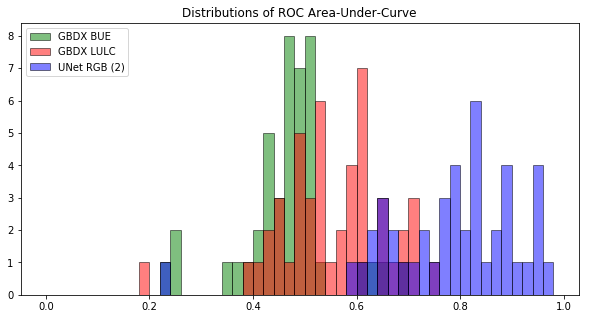

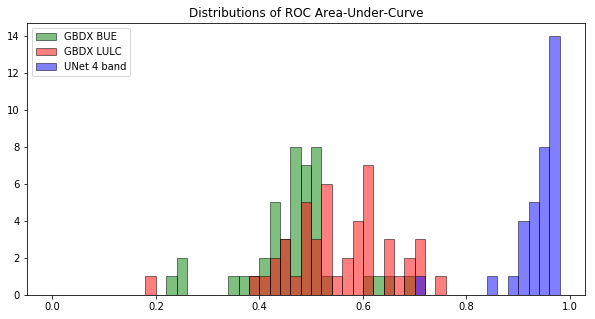

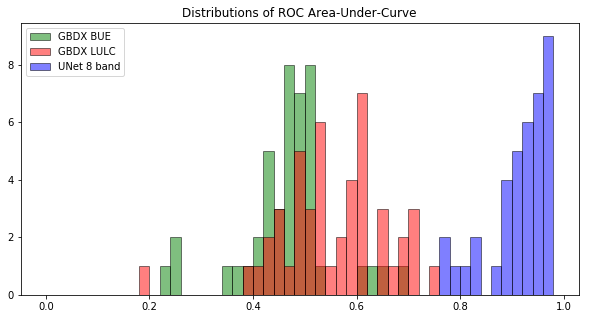

In [7]:
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

## iterate over the UNET rasters
labels=('UNet RGB (1)', 'UNet RGB (2)', 'UNet 4 band', 'UNet 8 band')
winsize=80
for im_UNet, unet_label in zip((im_UNet_RGB1, im_UNet_RGB2, im_UNet_4band, im_UNet_8band), labels):
    
    # open one of the UNet results
    with rio.open(im_UNet, 'r') as src:
        arr = src.read(1)

    rows = gt_arr.shape[1]
    cols = gt_arr.shape[2]
    dg_lulc_auc = []
    dg_lulc_fpr = []
    dg_lulc_tpr = []

    dg_bue_auc = []
    dg_bue_fpr = []
    dg_bue_tpr = []

    unet_auc = []
    unet_fpr = []
    unet_tpr = []
    for i in range(0,rows,winsize):
        for j in range(0,cols,winsize):

            # specify window coordinates (rows, cols)
            rmin = i
            rmax = rmin+64      
            cmin = j
            cmax = cmin+64
            #print(wmin, wmax)

            # get the gt window
            target = gt_arr[0, rmin:rmax, cmin:cmax]
            area_thresh = target[target>0].size / target.size

            # check the 80%
            if area_thresh > 0.8:

                try:

                    # for LULC
                    pred = manmade[rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    dg_lulc_auc.append(roc_auc)
                    dg_lulc_fpr.append(false_positive_rate)
                    dg_lulc_tpr.append(true_positive_rate)

                    # for UNet
                    pred = arr[rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    unet_auc.append(roc_auc)
                    unet_fpr.append(false_positive_rate)
                    unet_tpr.append(true_positive_rate)

                    # for BUE
                    pred = dg_bue_arr[0, rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    dg_bue_auc.append(roc_auc)
                    dg_bue_fpr.append(false_positive_rate)
                    dg_bue_tpr.append(true_positive_rate)

                except:
                    # we likely have a dimension mismatch
                    continue
                    
    # show the distribution of ROC AUC (area under curve)
    plt.figure(figsize=(10,5))
    res = 0.02
    plt.hist(dg_bue_auc, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
    plt.hist(dg_lulc_auc, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
    plt.hist(unet_auc, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
    plt.legend(loc='upper left')
    plt.title('Distributions of ROC Area-Under-Curve')
    plt.show()
    
    # pick a random sample for TPR vs FPR
#     plt.figure(figsize=(10,5))
#     plt.plot(dg_bue_fpr[10], dg_bue_tpr[10], c='g')
#     plt.plot(dg_lulc_fpr[10], dg_lulc_tpr[10], c='r')
#     plt.plot(unet_fpr[10], unet_tpr[10], c='b')
#     plt.show()



## Single plot for UNet results

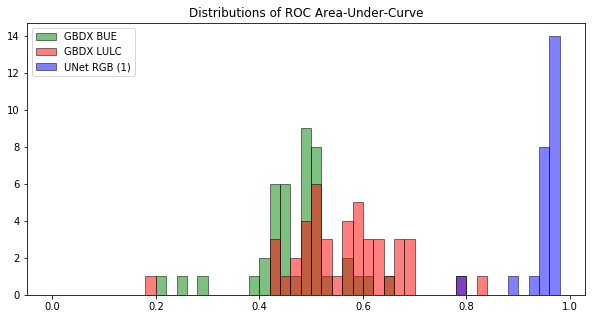

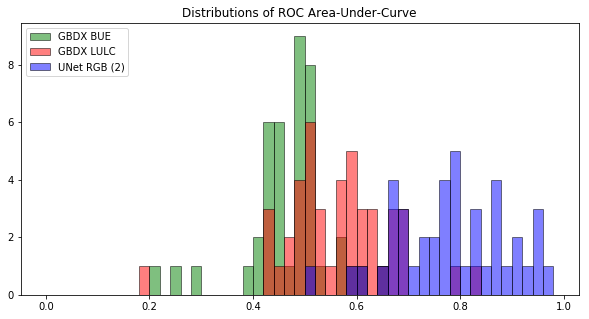

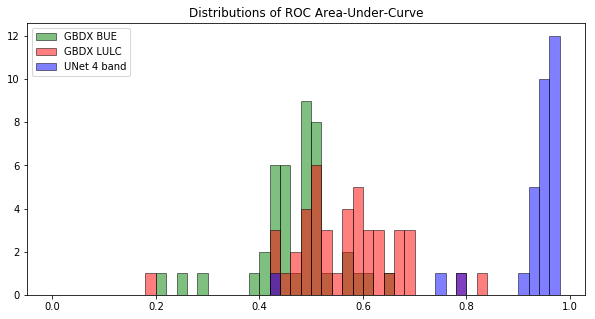

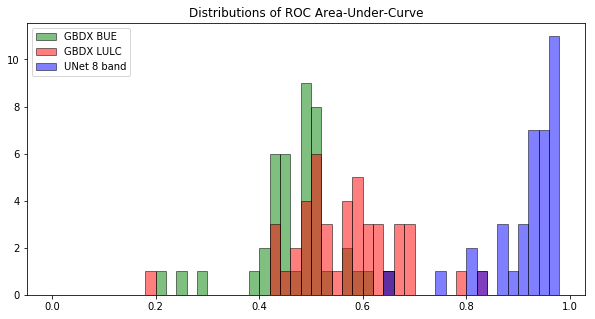

In [8]:
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

## iterate over the UNET rasters
labels=('UNet RGB (1)', 'UNet RGB (2)', 'UNet 4 band', 'UNet 8 band')
unet_fpr_all = []
unet_tpr_all = []

for im_UNet, unet_label in zip((im_UNet_RGB1, im_UNet_RGB2, im_UNet_4band, im_UNet_8band), labels):
    
    # open one of the UNet results
    with rio.open(im_UNet, 'r') as src:
        arr = src.read(1)

    rows = gt_arr.shape[1]
    cols = gt_arr.shape[2]
    dg_lulc_auc = []
    dg_lulc_fpr = []
    dg_lulc_tpr = []

    dg_bue_auc = []
    dg_bue_fpr = []
    dg_bue_tpr = []

    unet_auc = []
    unet_fpr = []
    unet_tpr = []
    
    r,c = [],[]
    for i in range(0,rows,winsize):
        for j in range(0,cols,winsize):

            # specify window coordinates (rows, cols)
            rmin = i
            rmax = rmin+winsize      
            cmin = j
            cmax = cmin+winsize
            #print(wmin, wmax)

            # get the gt window
            target = gt_arr[0, rmin:rmax, cmin:cmax]
            area_thresh = target[target>0].size / target.size

            # check the 80%
            if area_thresh > 0.8:

                try:

                    # for LULC
                    pred = manmade[rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    dg_lulc_auc.append(roc_auc)
                    dg_lulc_fpr.append(false_positive_rate)
                    dg_lulc_tpr.append(true_positive_rate)

                    # for UNet
                    pred = arr[rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    unet_auc.append(roc_auc)
                    unet_fpr.append(false_positive_rate)
                    unet_tpr.append(true_positive_rate)

                    # for BUE
                    pred = dg_bue_arr[0, rmin:rmax, cmin:cmax]
                    roc_score = roc_auc_score(target.flatten(), pred.flatten())
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    dg_bue_auc.append(roc_auc)
                    dg_bue_fpr.append(false_positive_rate)
                    dg_bue_tpr.append(true_positive_rate)
                    
                    r.append(i)
                    c.append(j)

                except:
                    # we likely have a dimension mismatch
                    continue
    
    # append UNet results to list
    unet_tpr_all.append(unet_tpr)
    unet_fpr_all.append(unet_fpr)
    
    # show the distribution of ROC AUC (area under curve)
    plt.figure(figsize=(10,5))
    res = 0.02
    plt.hist(dg_bue_auc, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
    plt.hist(dg_lulc_auc, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
    plt.hist(unet_auc, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
    plt.legend(loc='upper left')
    plt.title('Distributions of ROC Area-Under-Curve')
    plt.show()

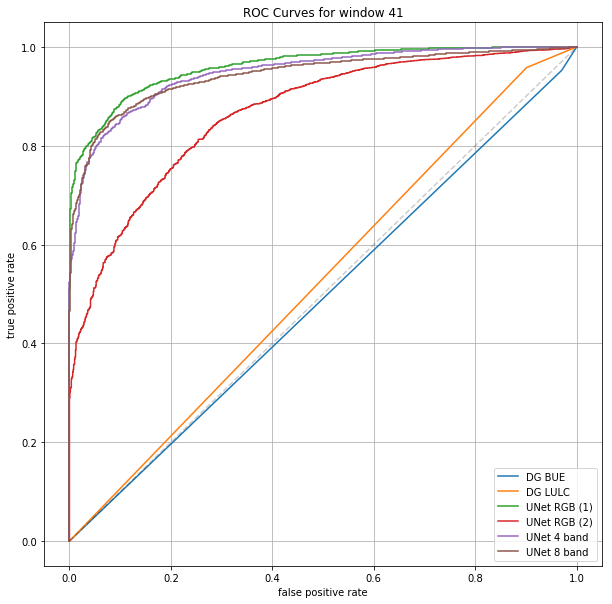

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


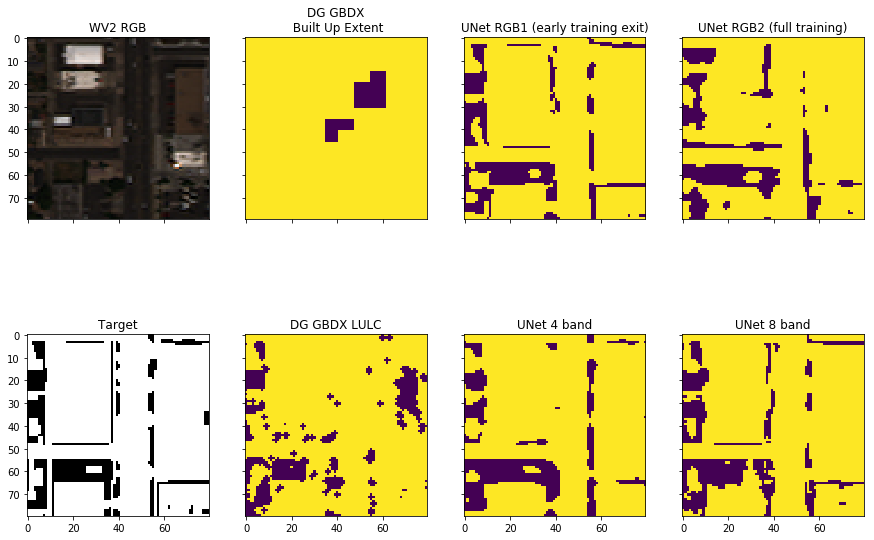

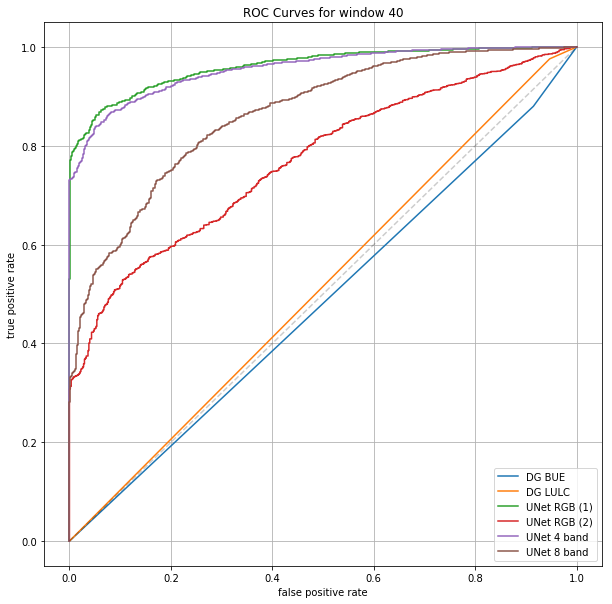

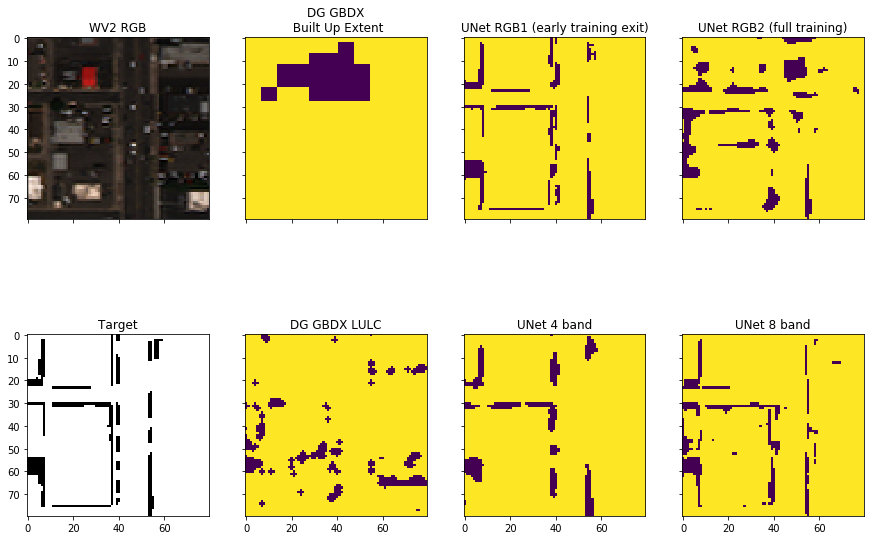

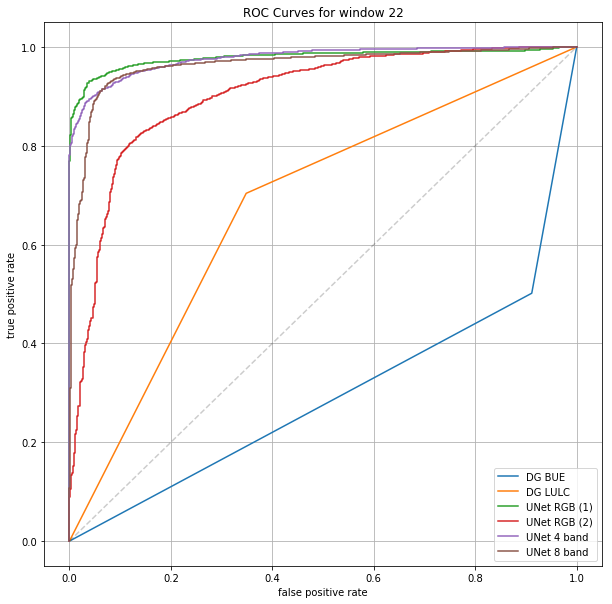

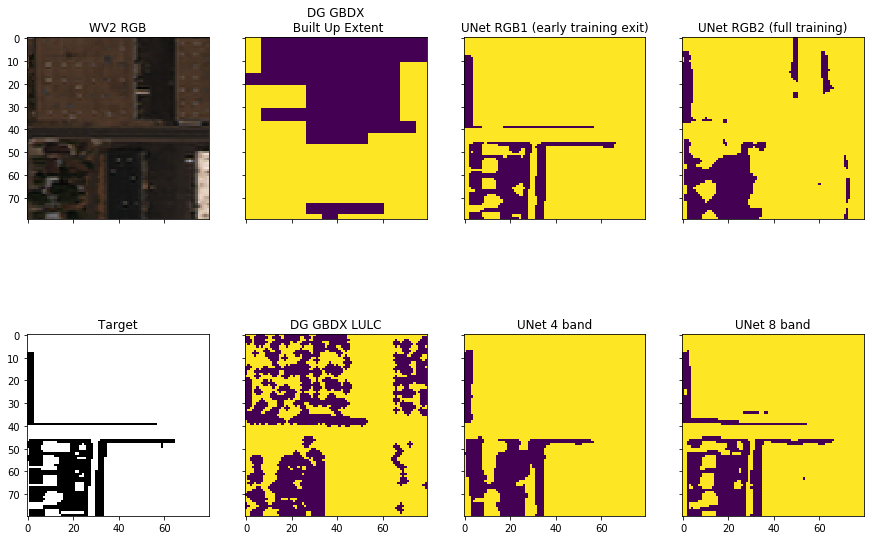

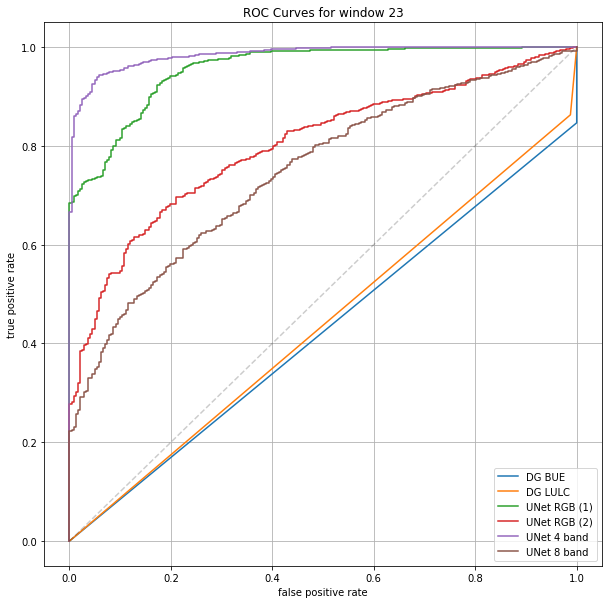

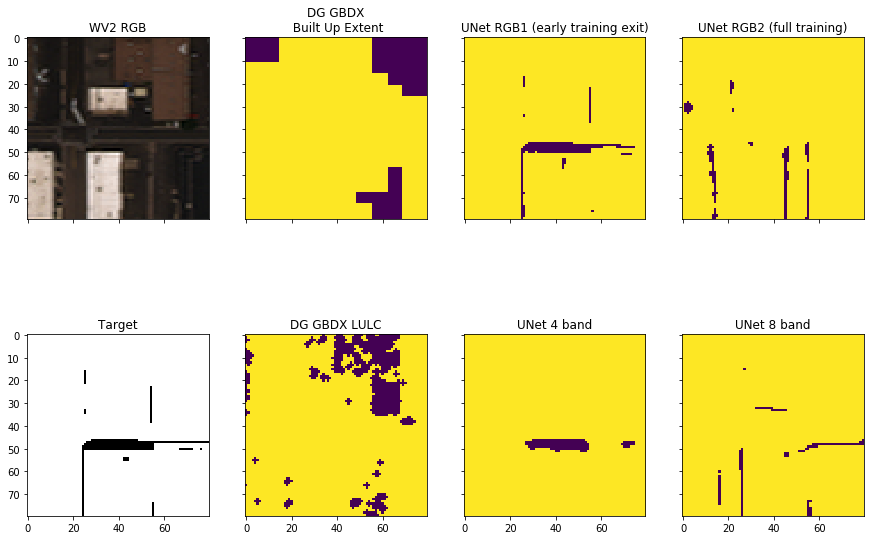

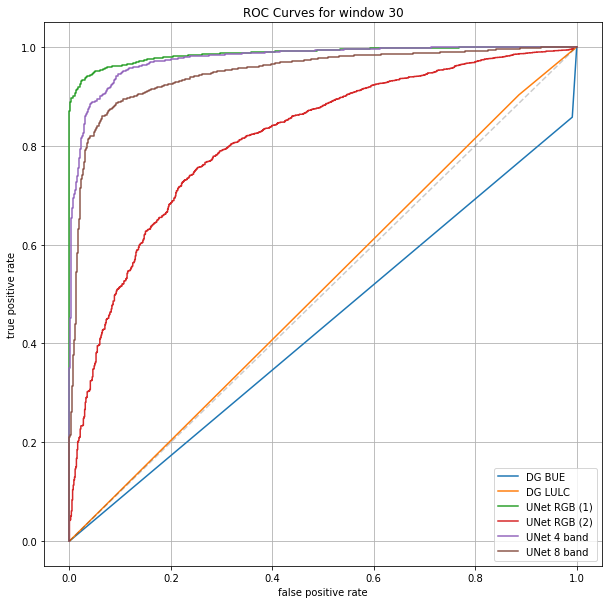

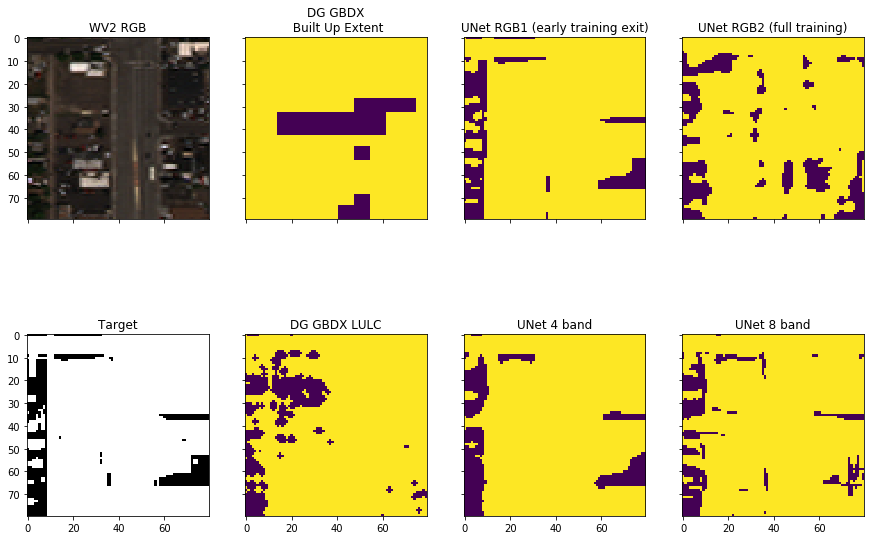

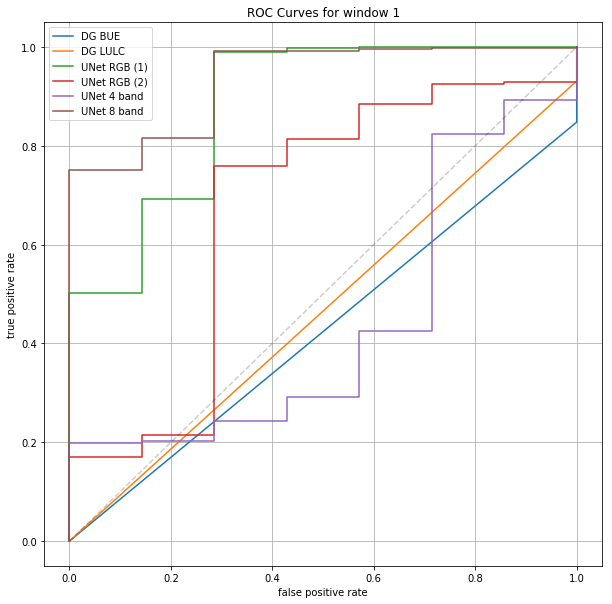

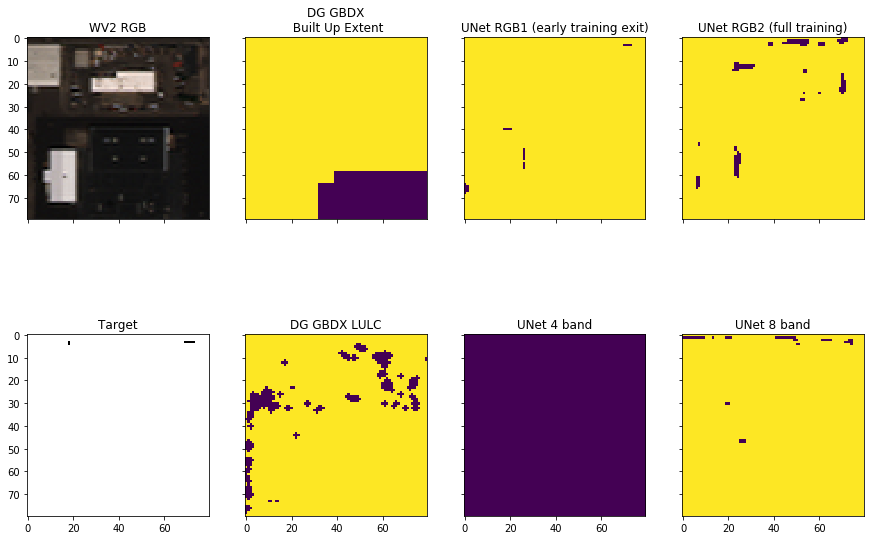

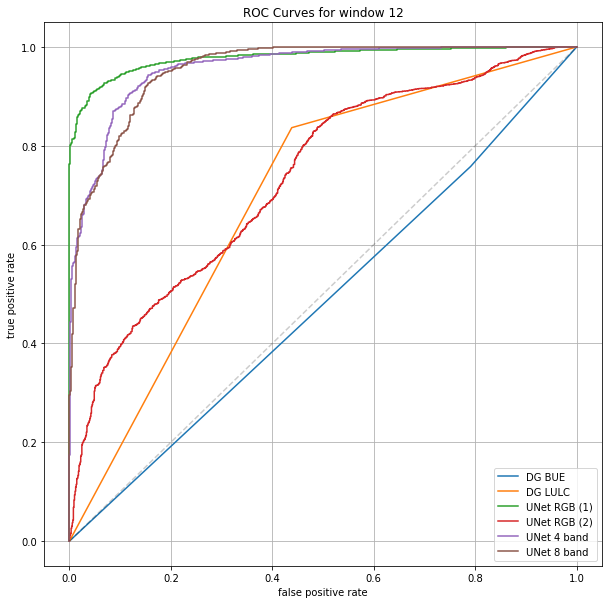

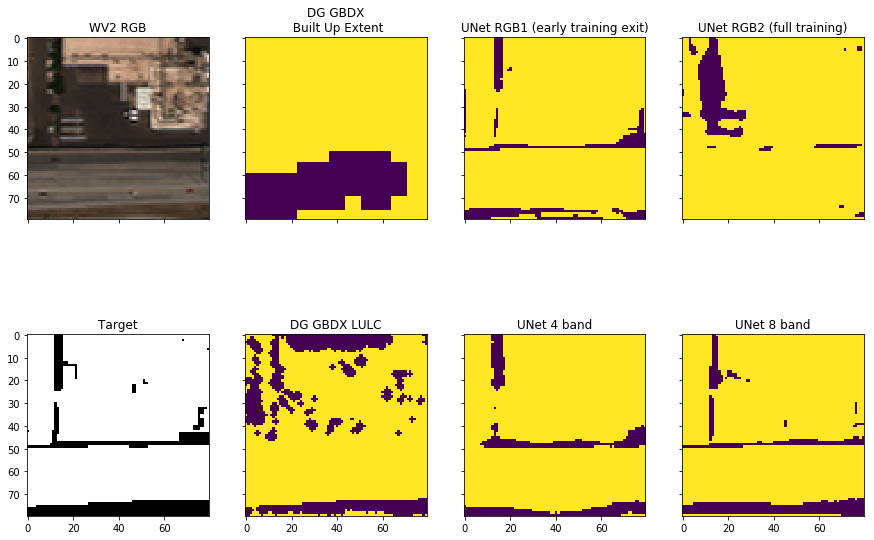

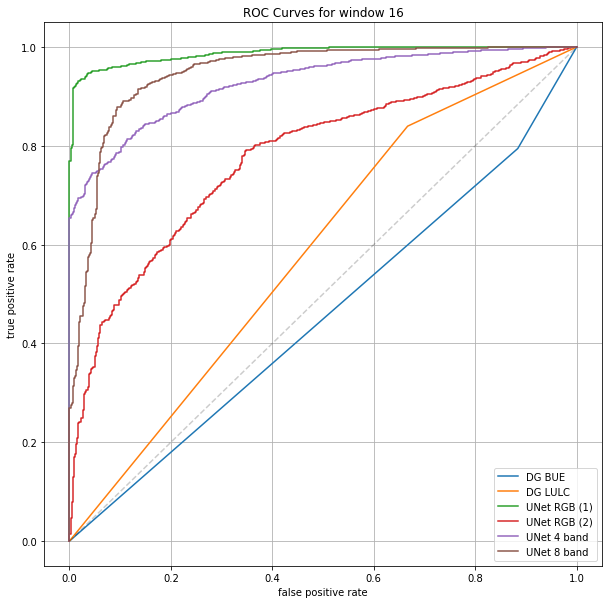

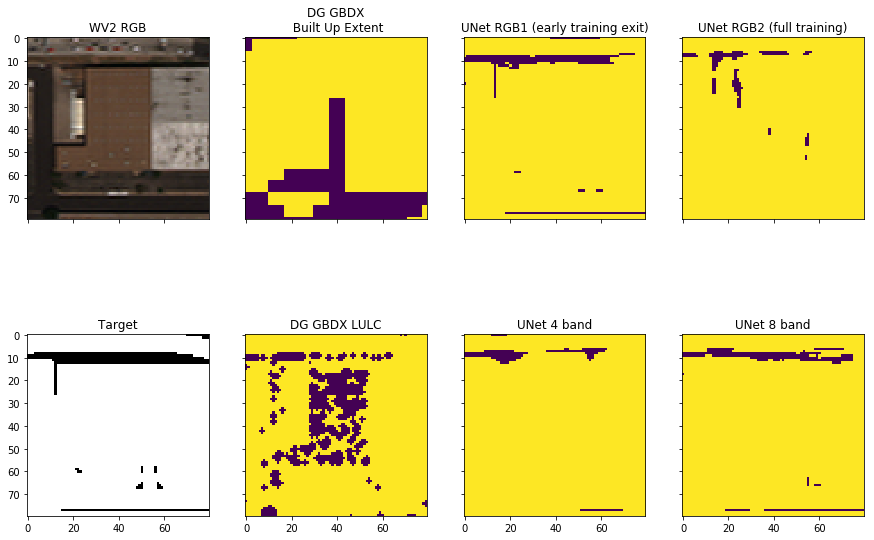

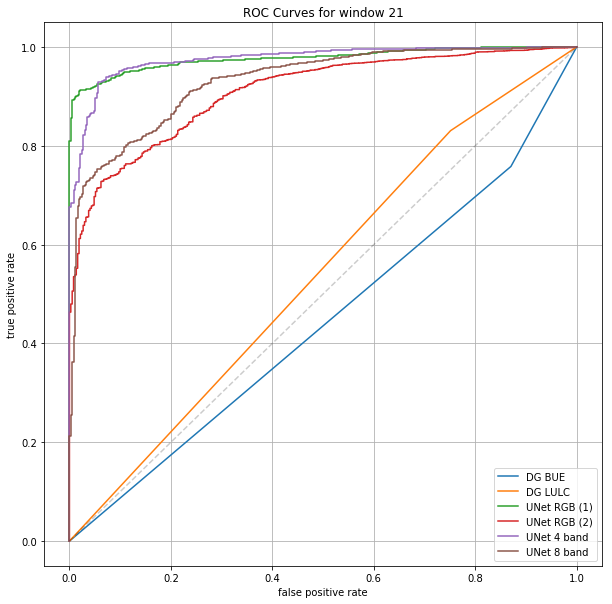

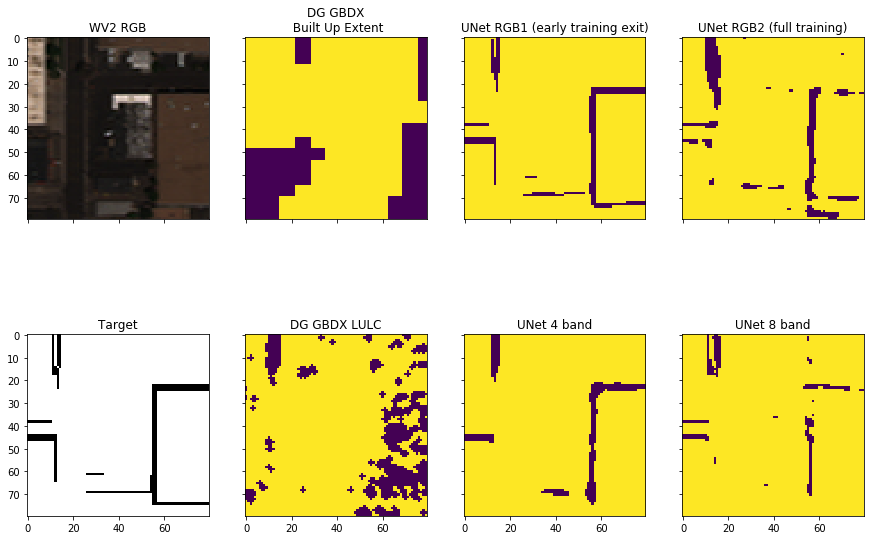

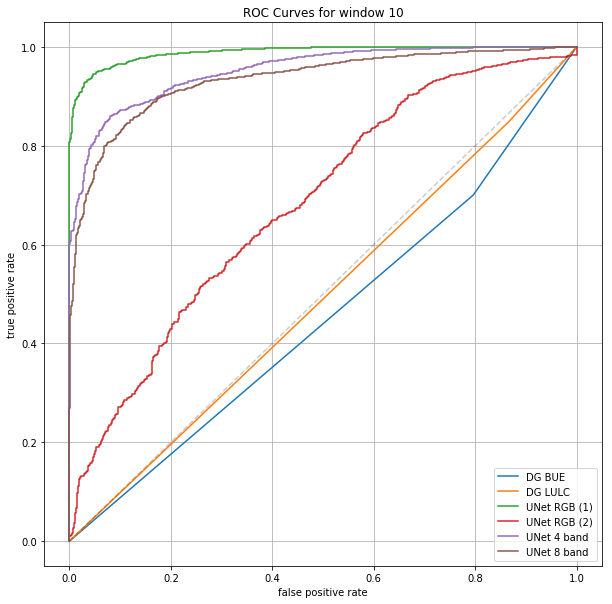

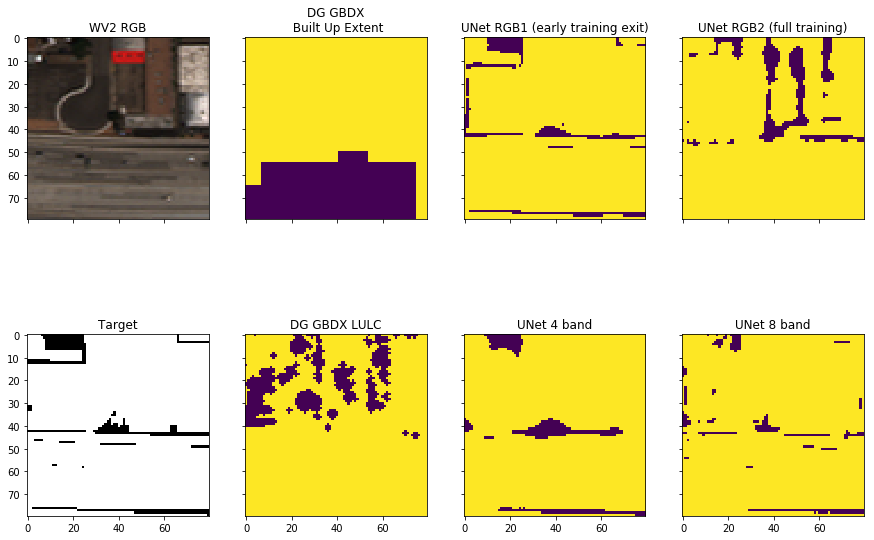

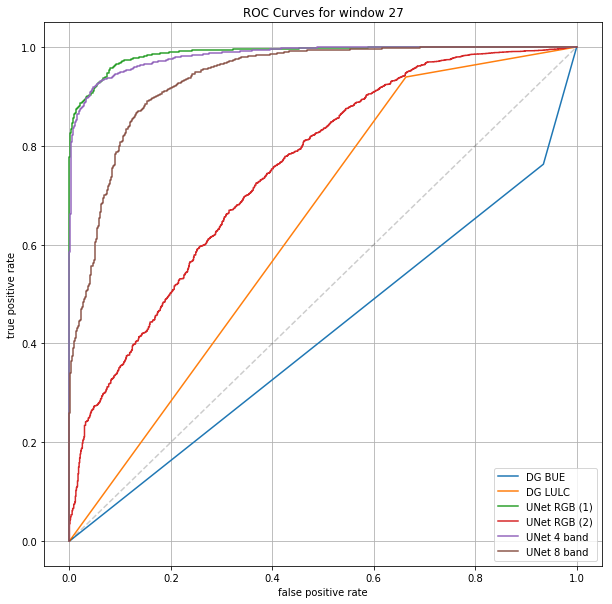

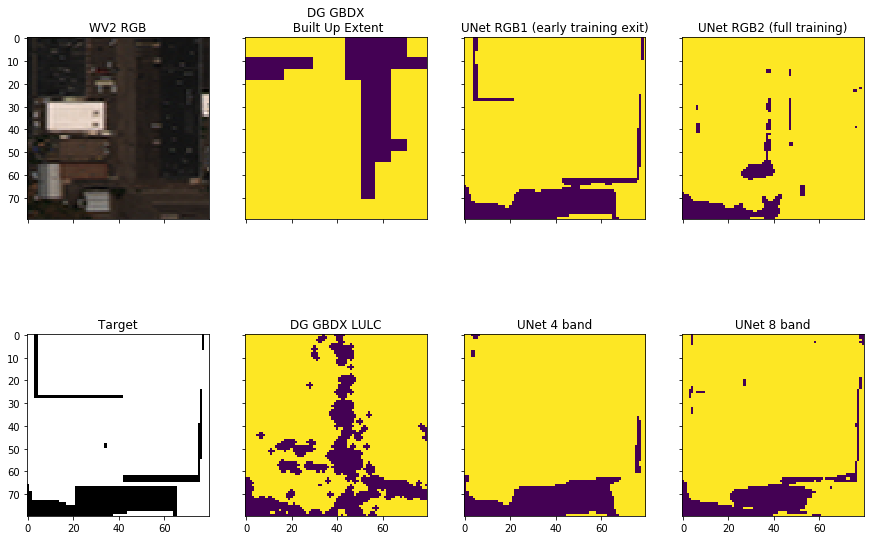

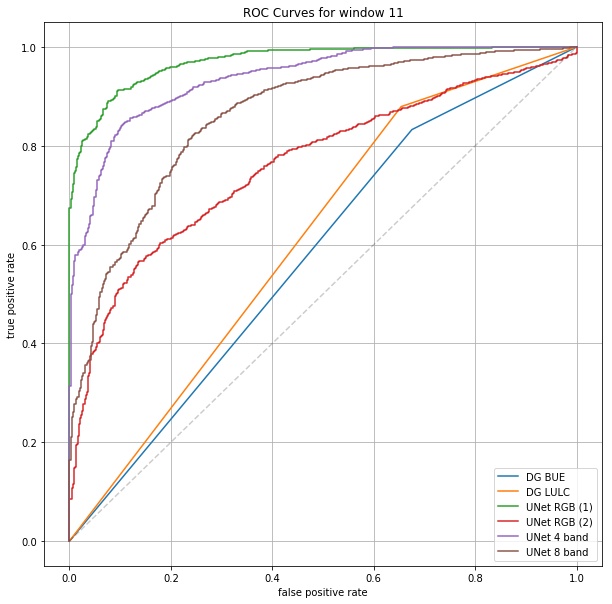

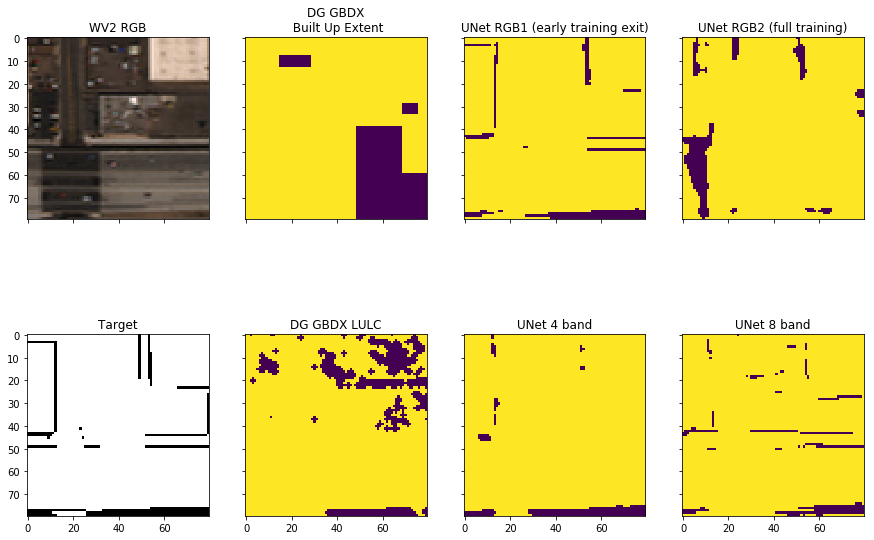

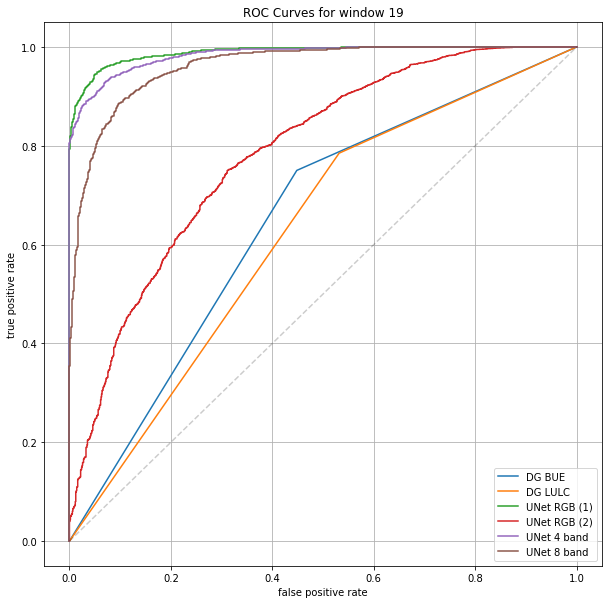

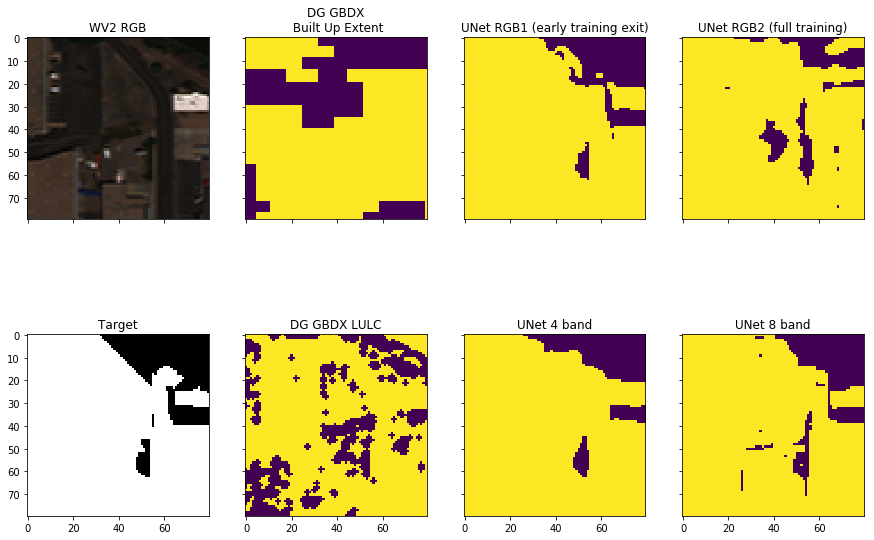

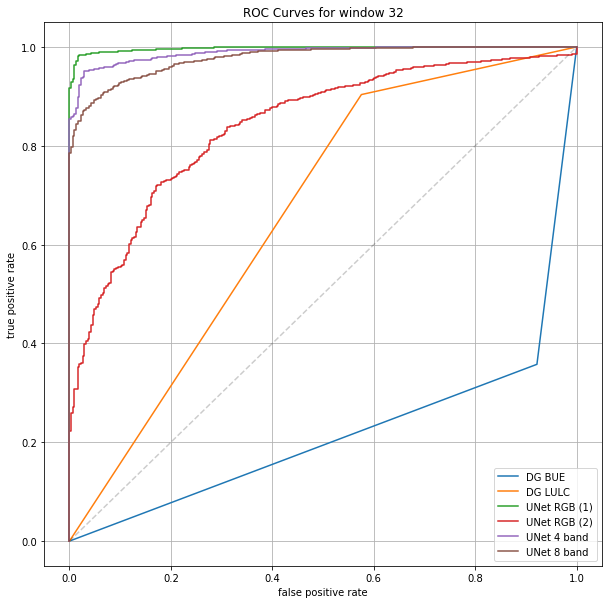

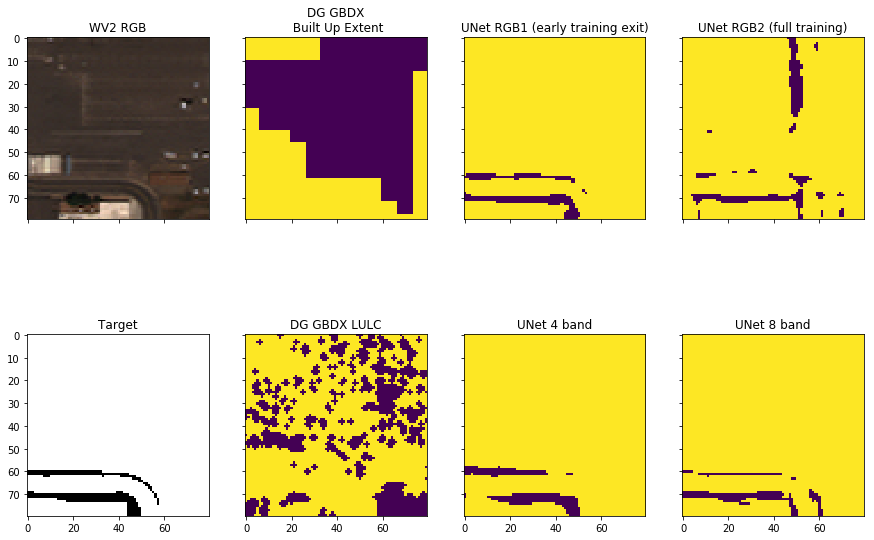

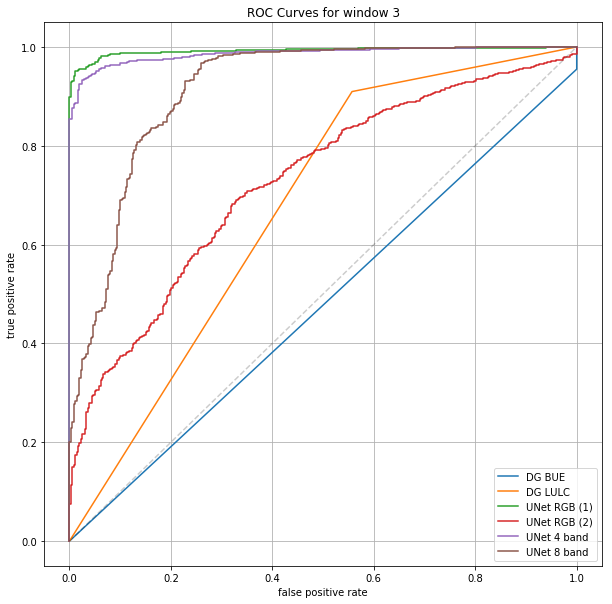

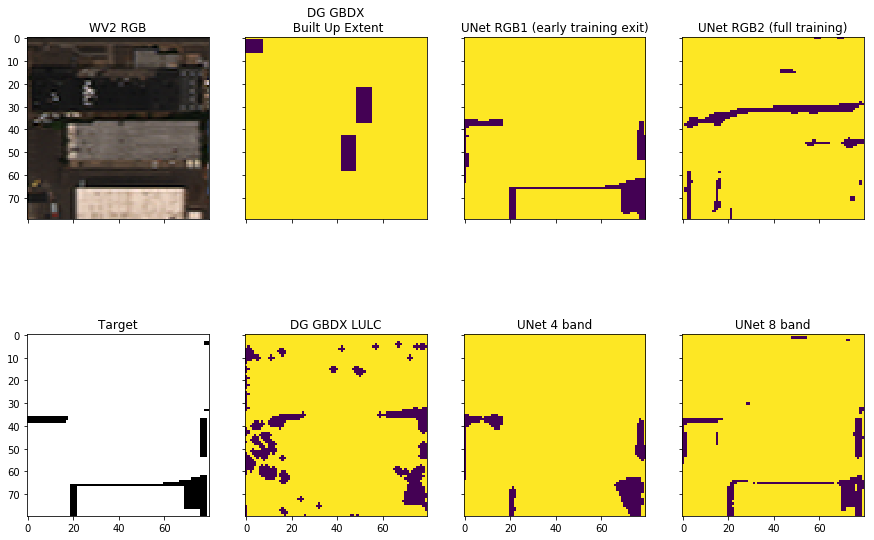

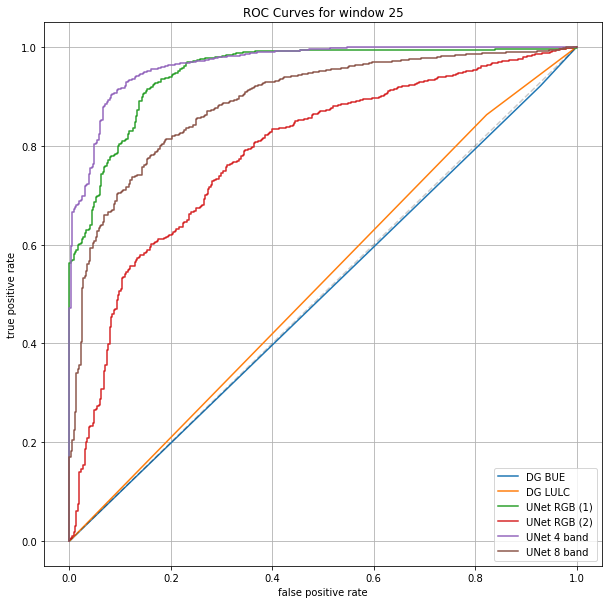

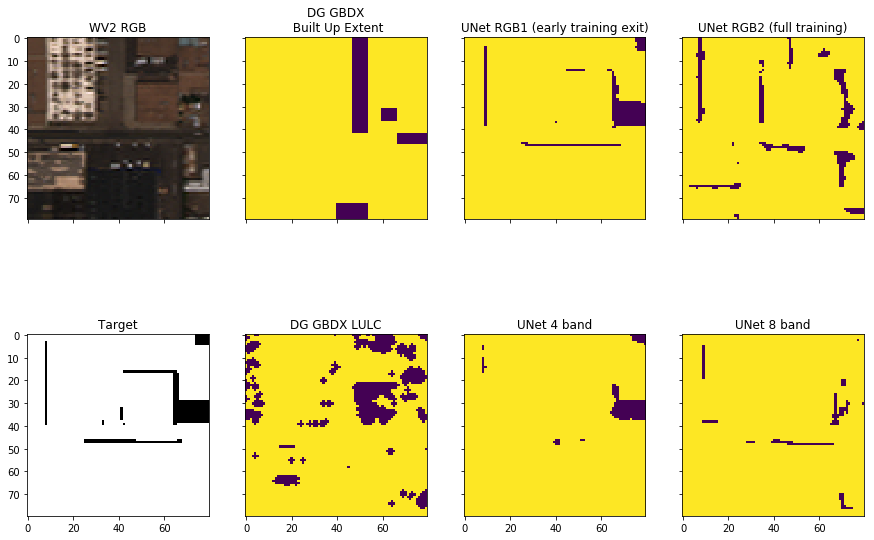

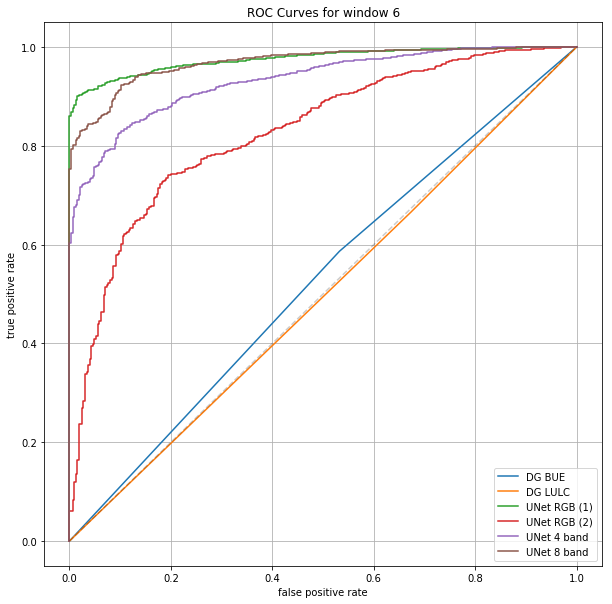

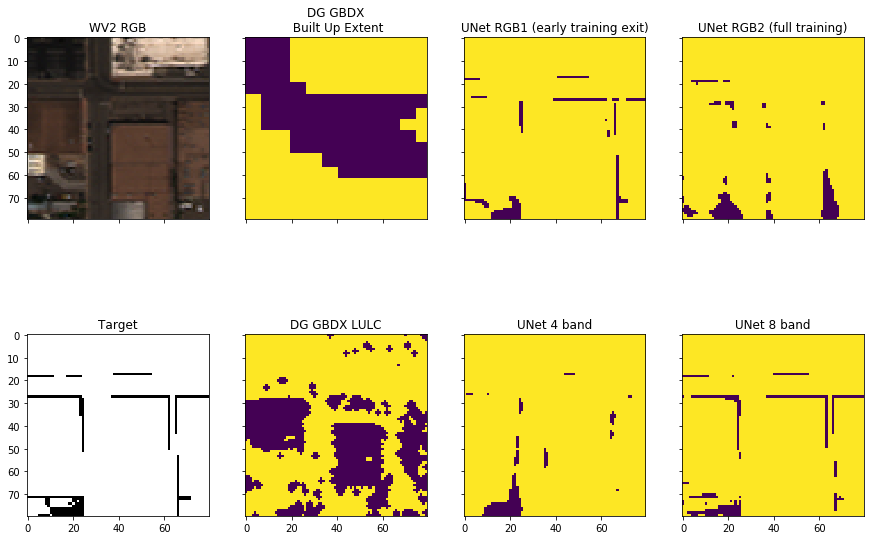

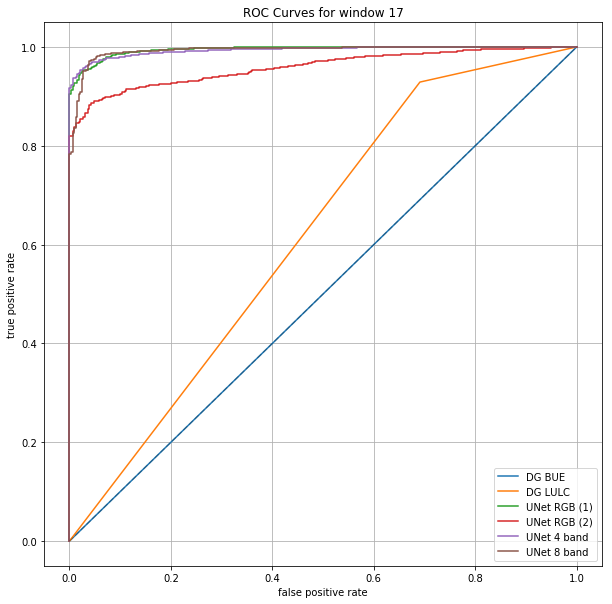

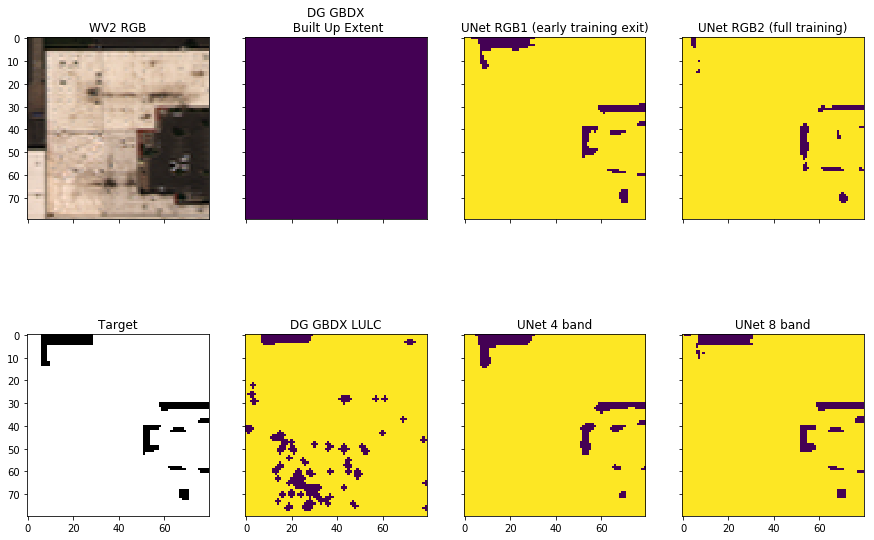

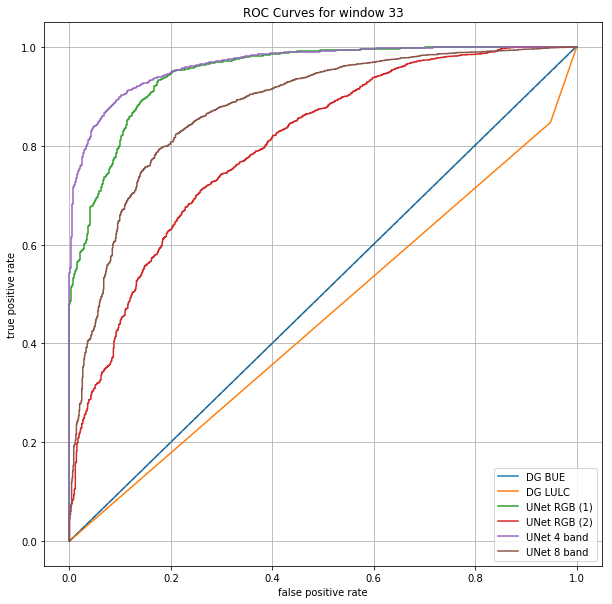

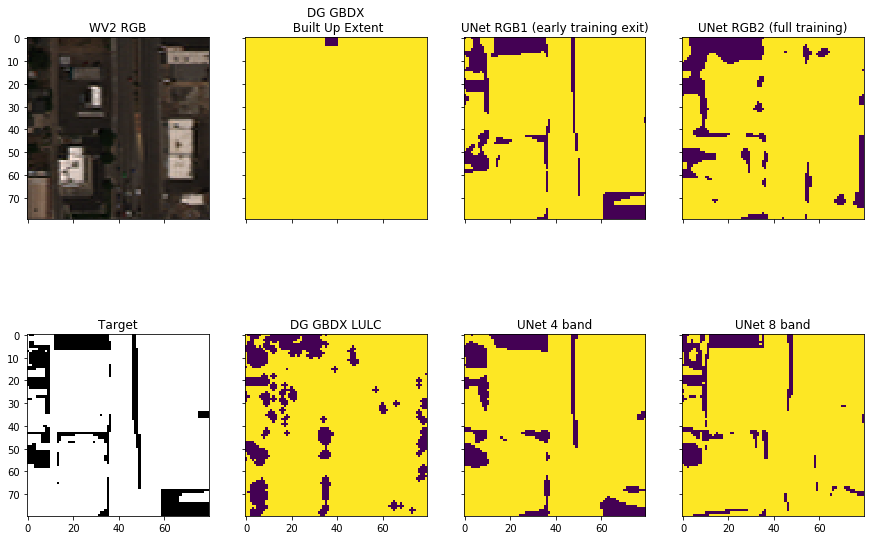

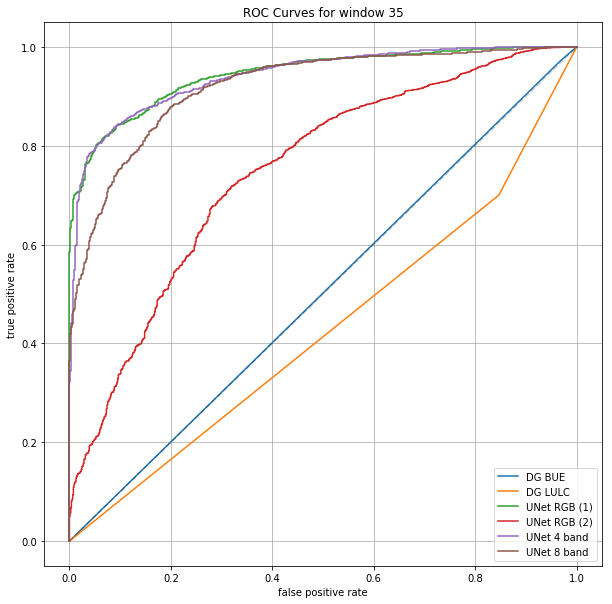

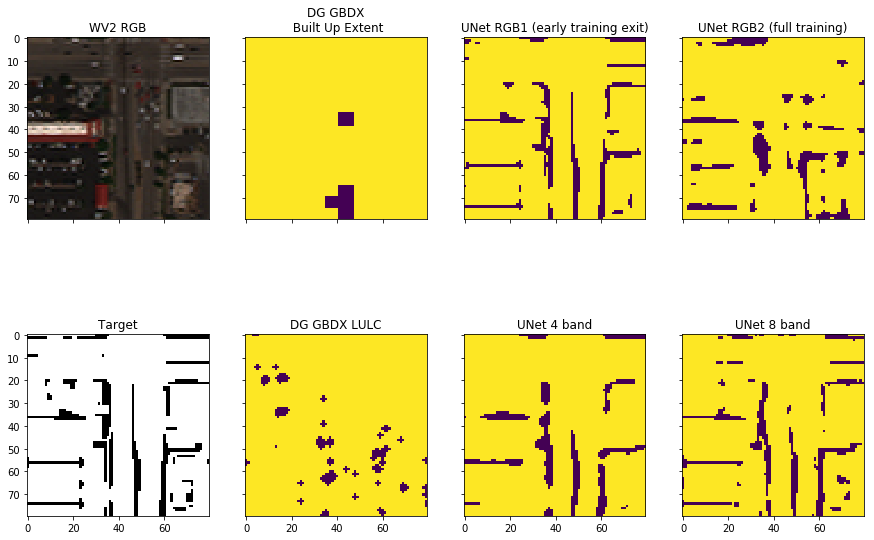

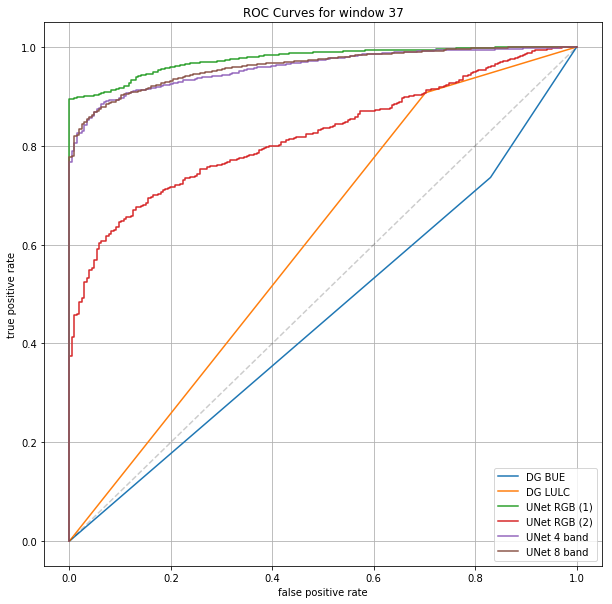

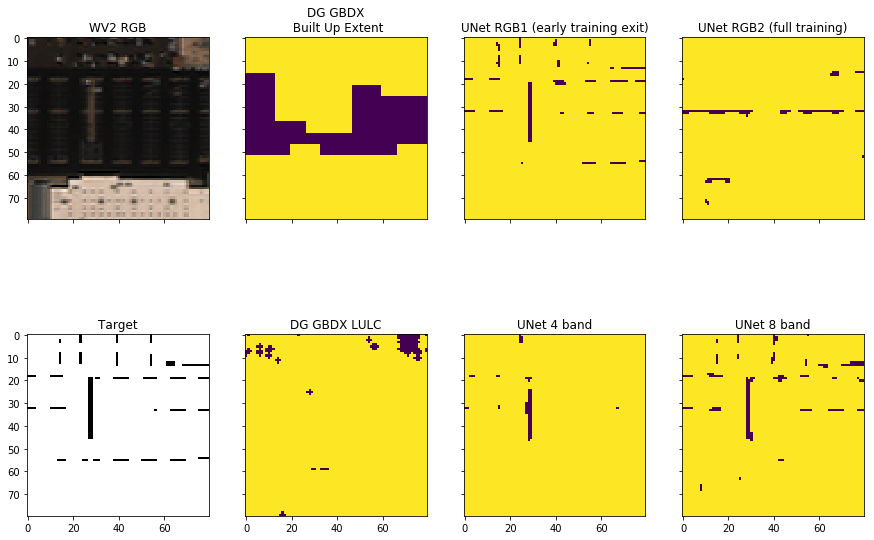

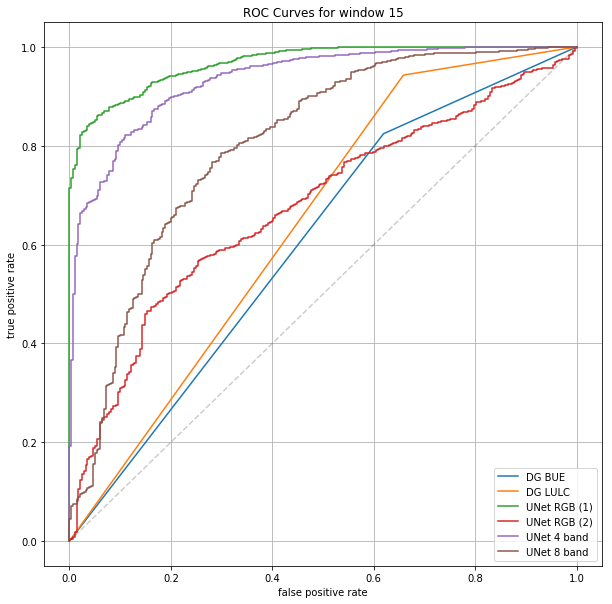

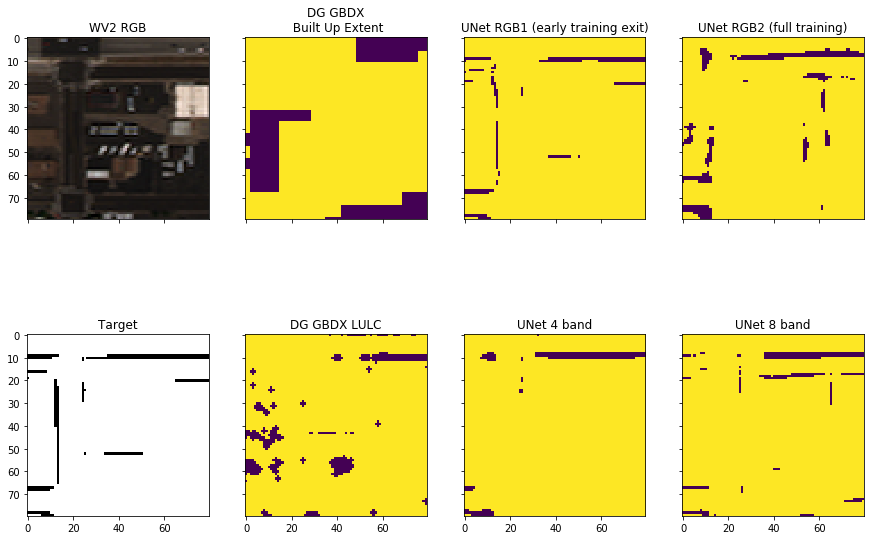

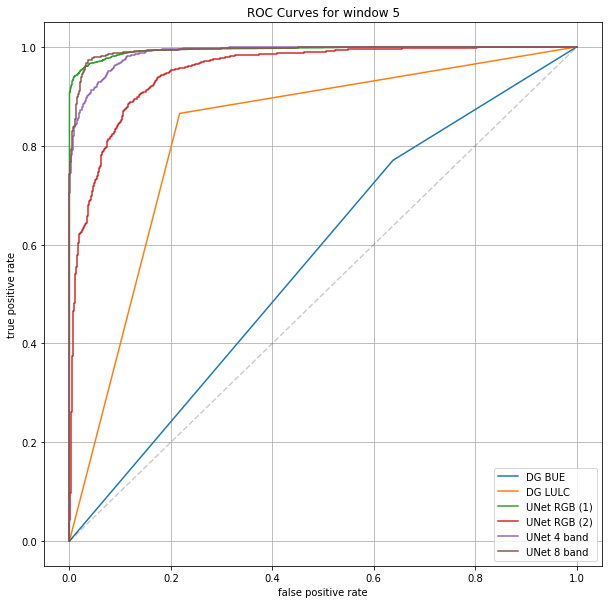

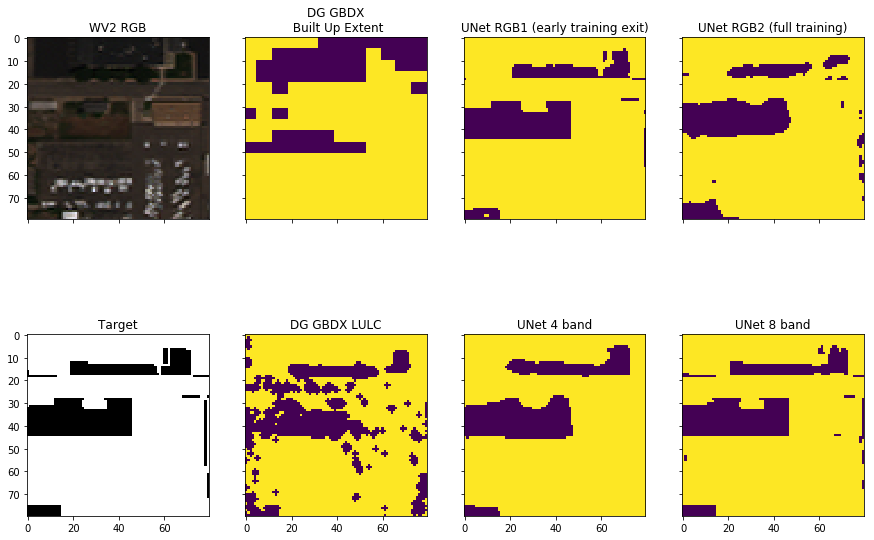

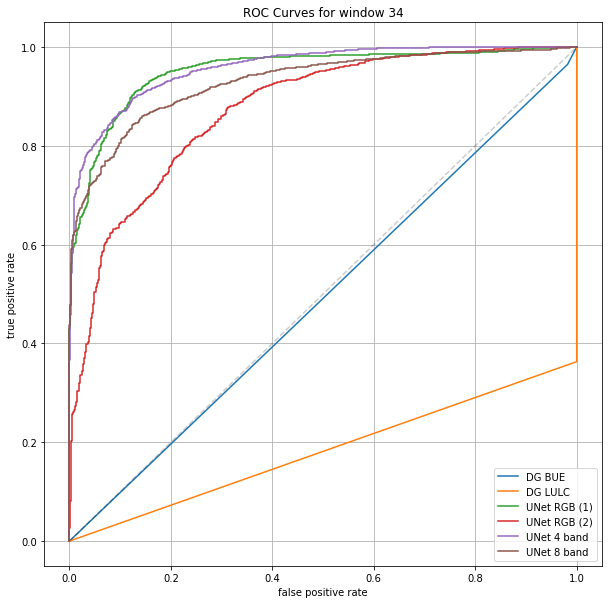

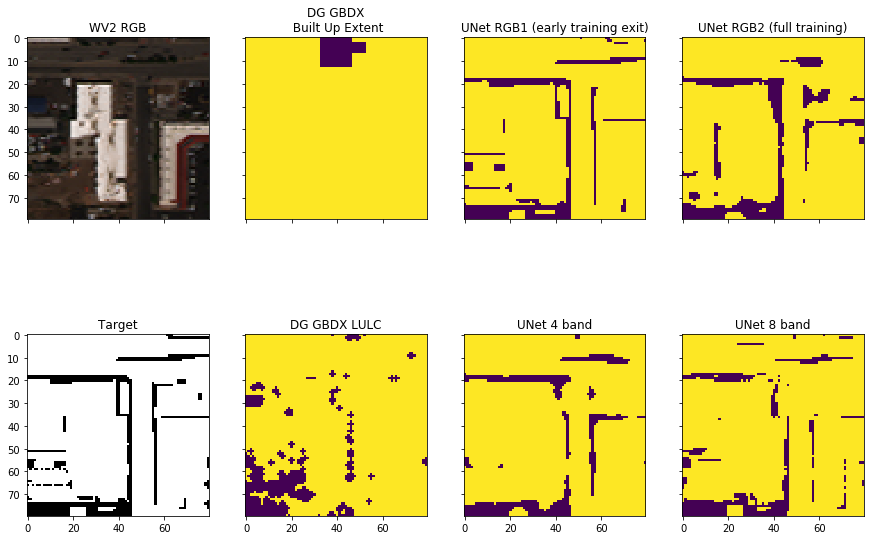

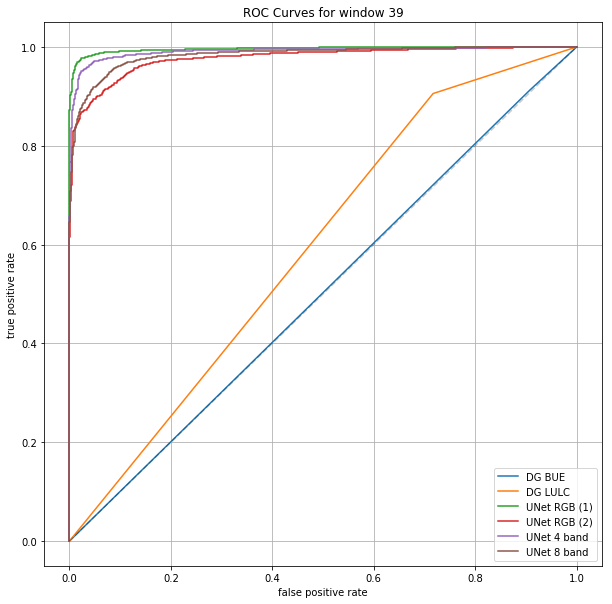

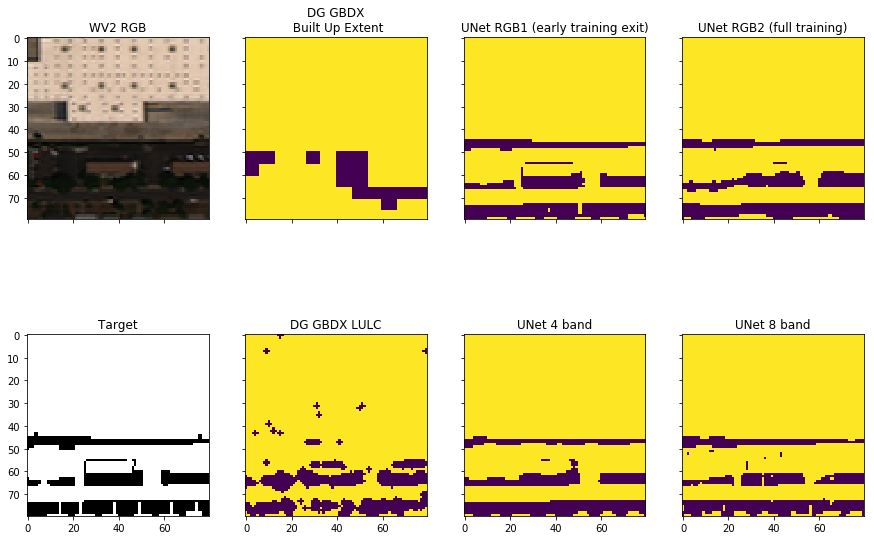

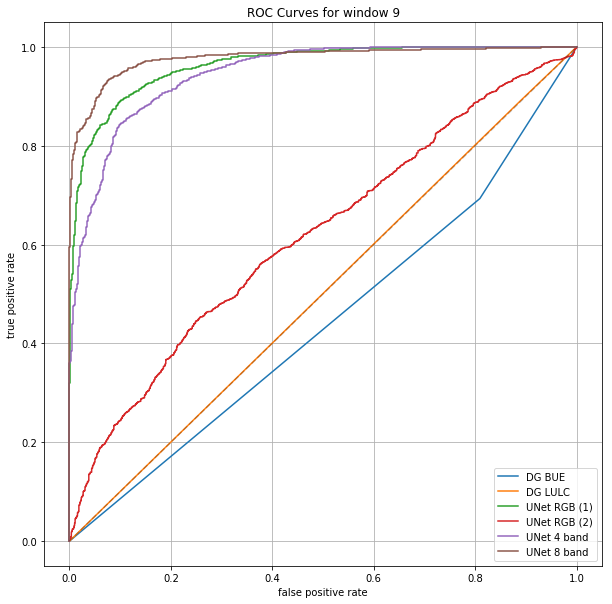

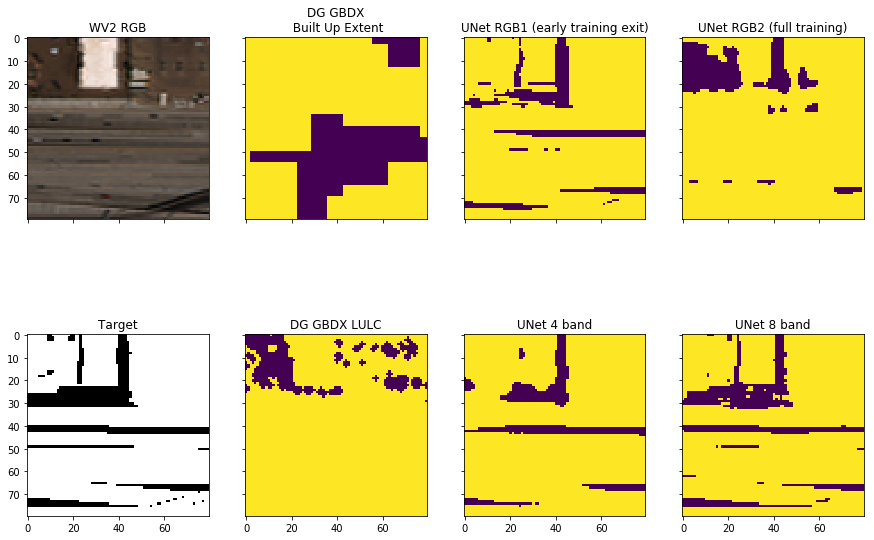

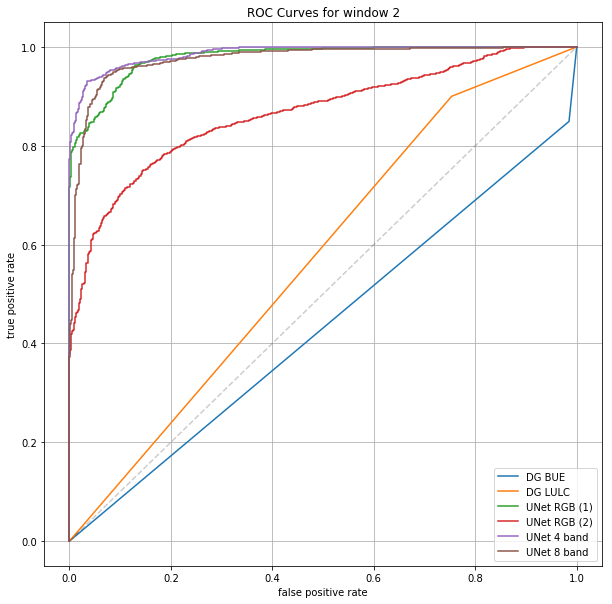

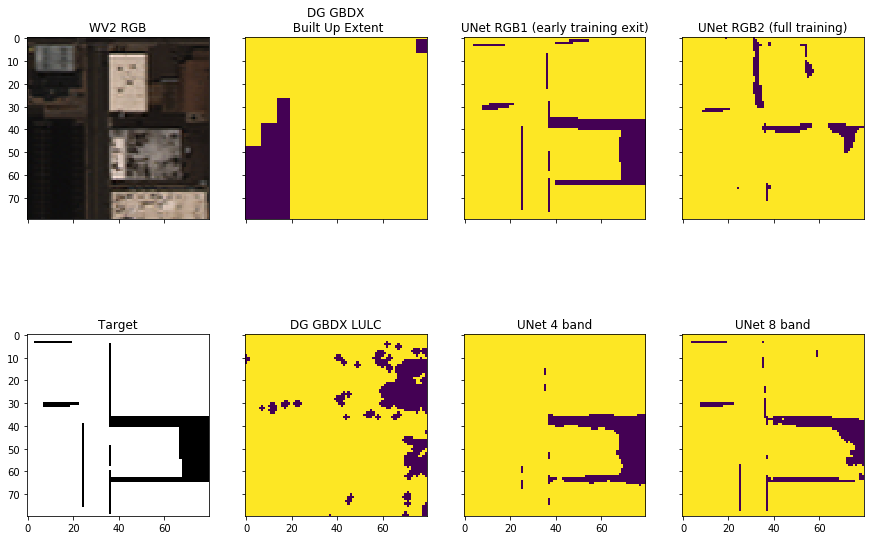

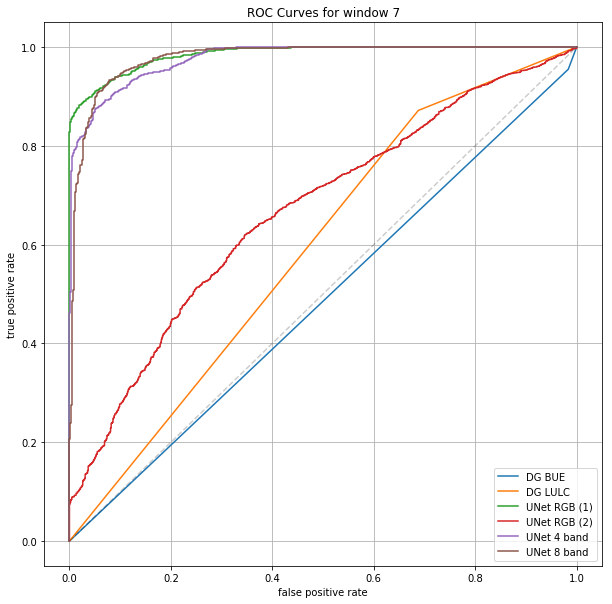

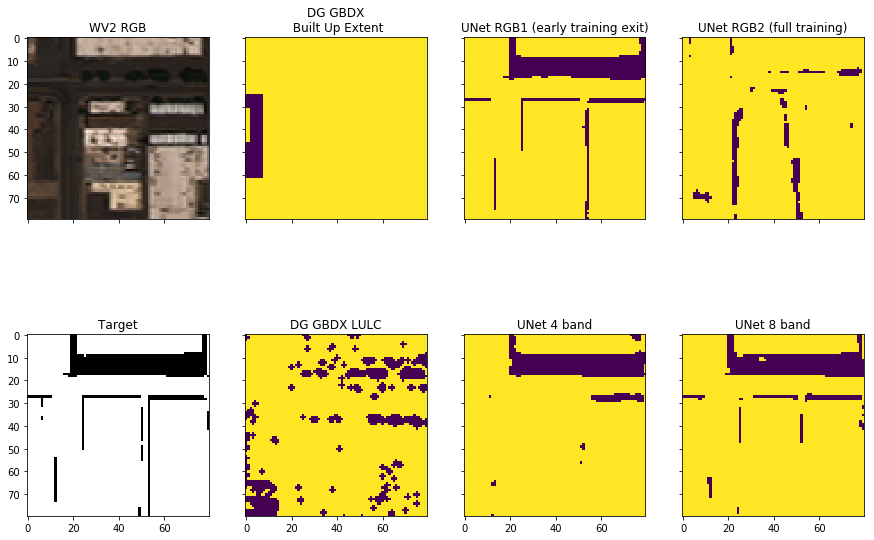

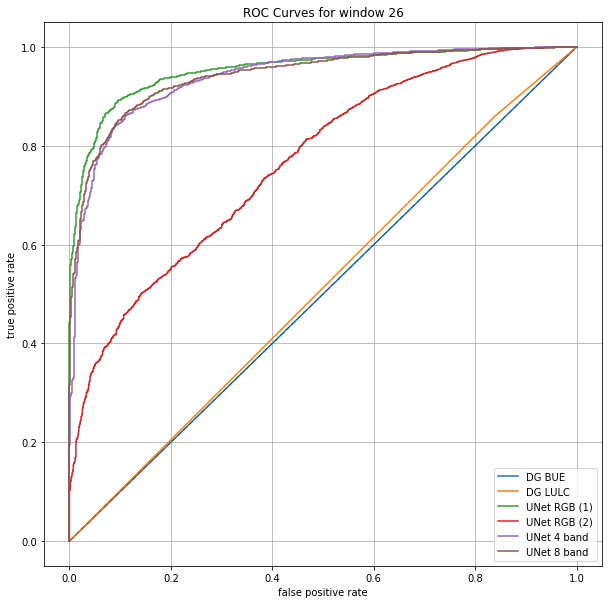

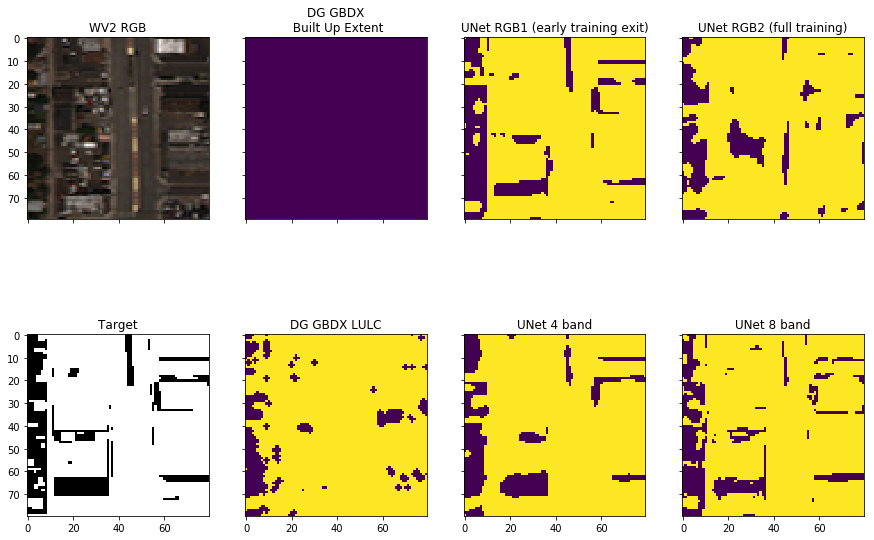

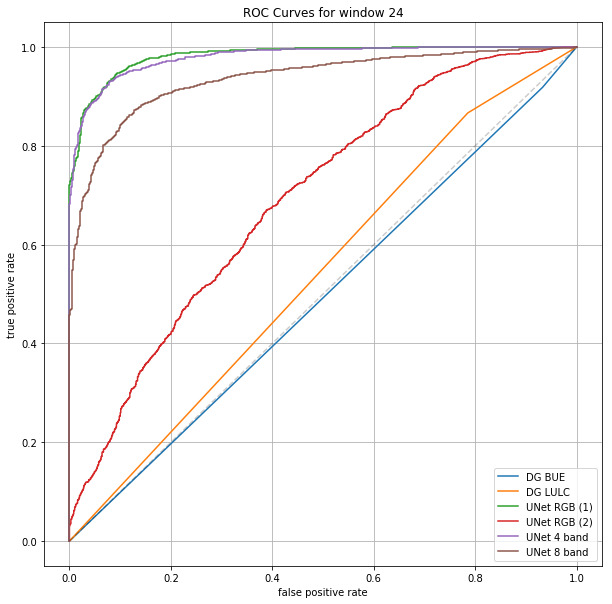

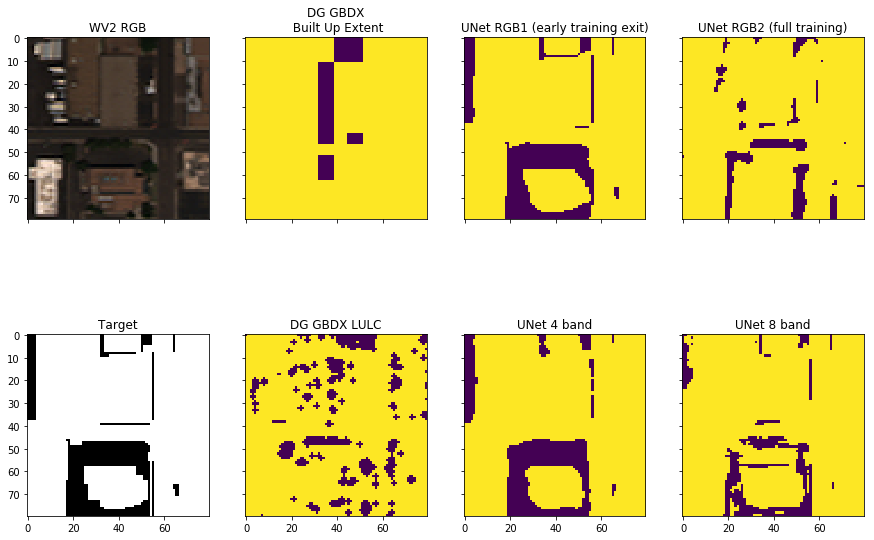

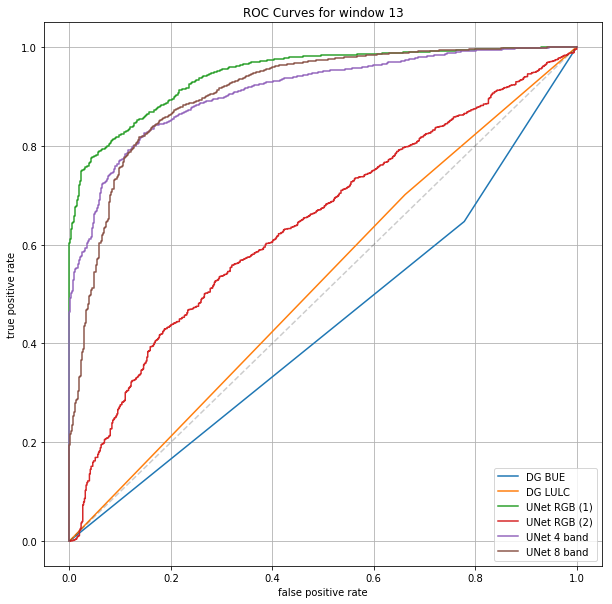

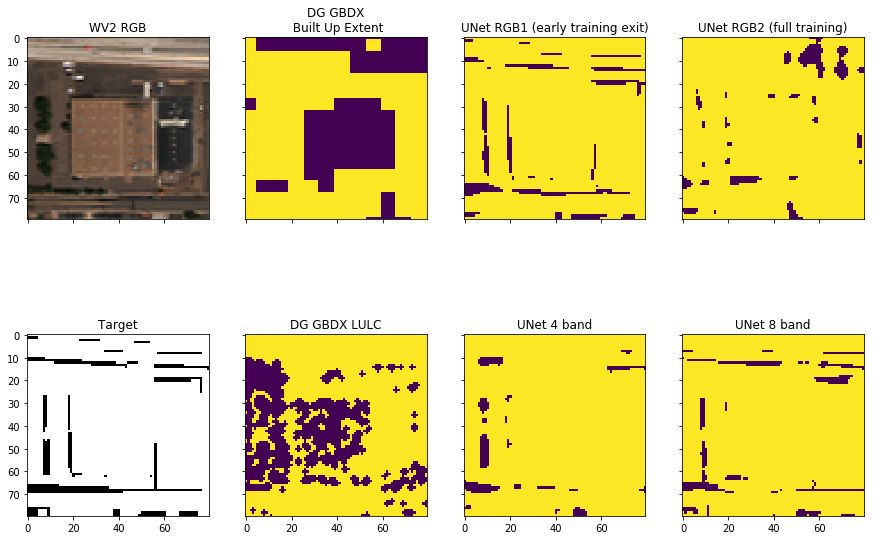

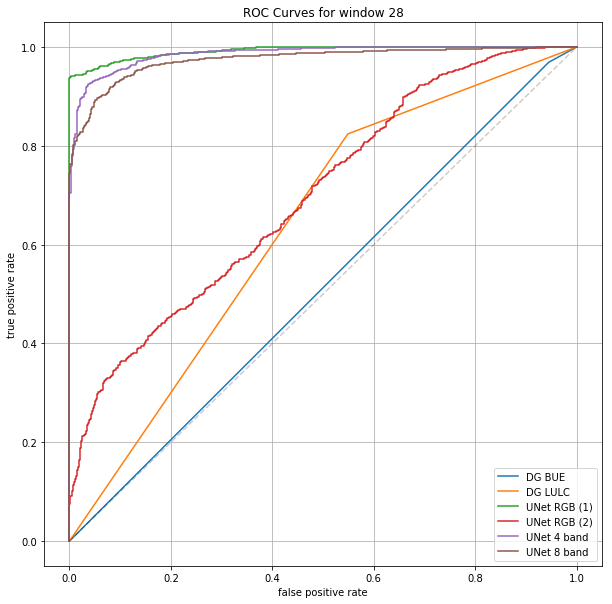

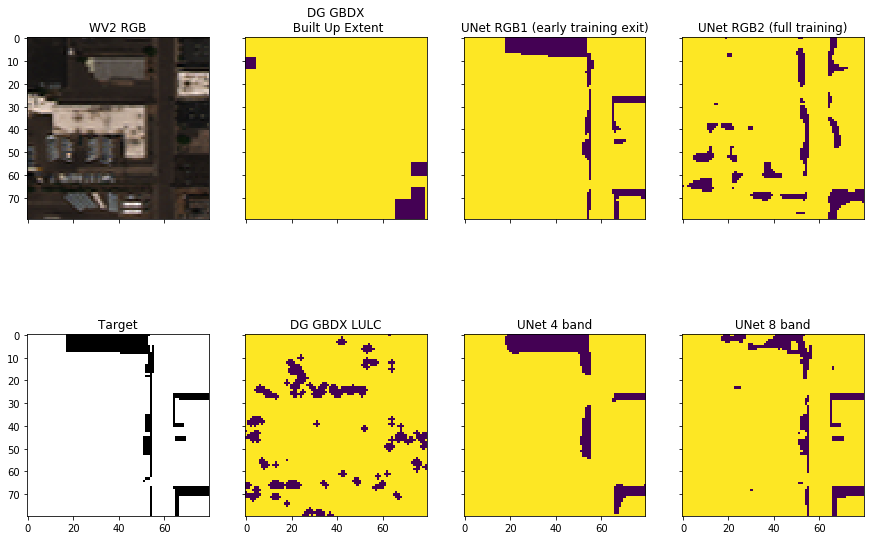

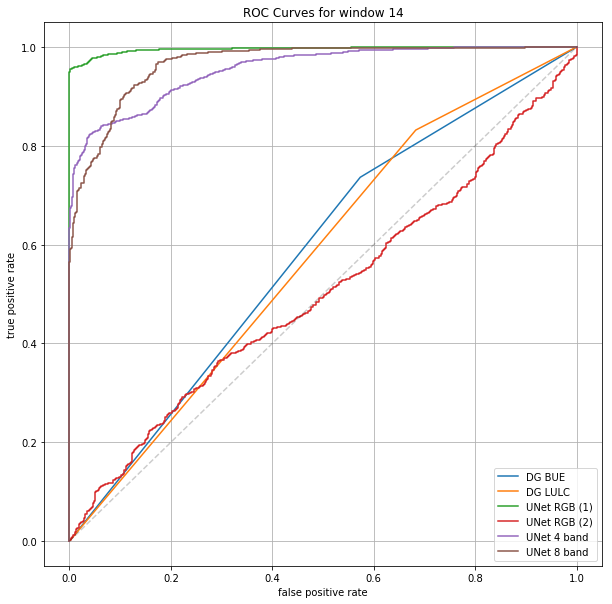

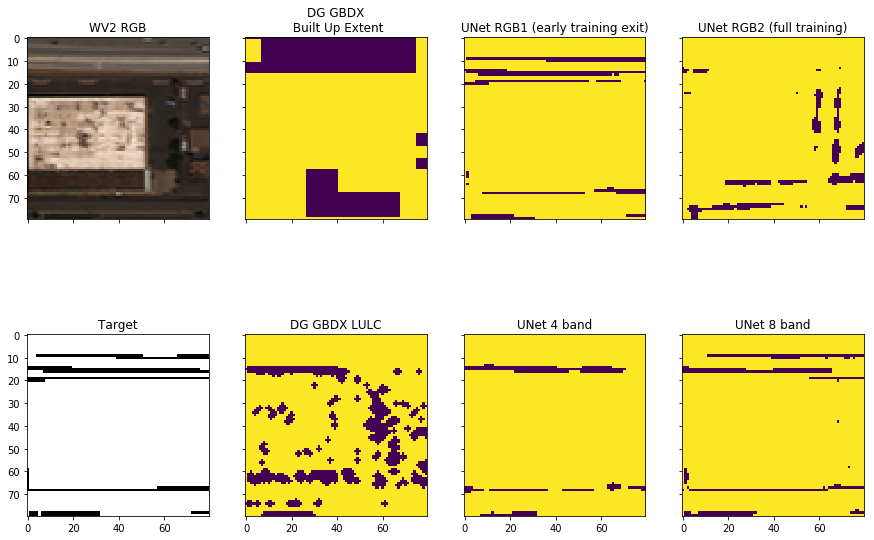

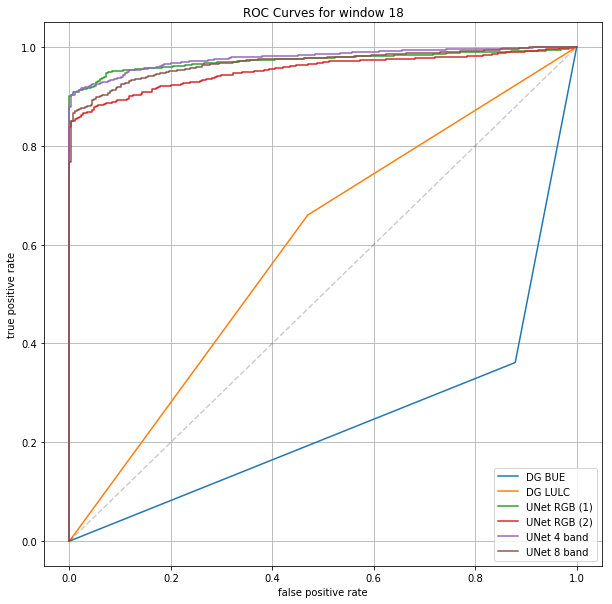

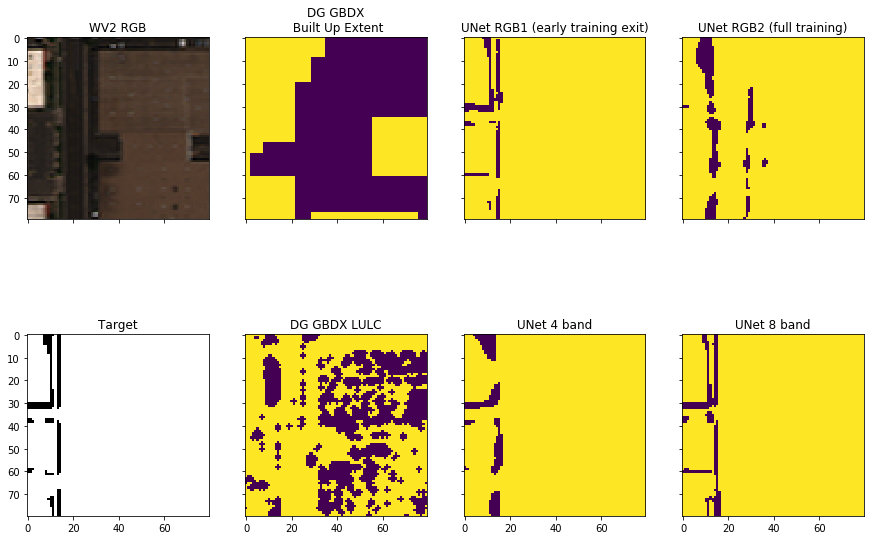

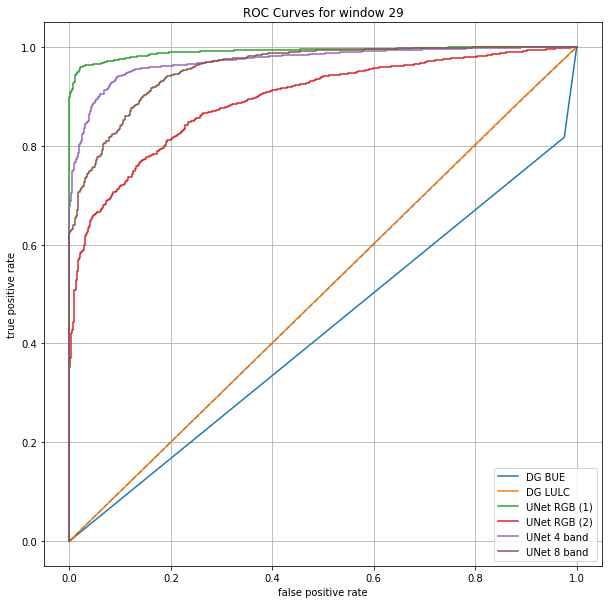

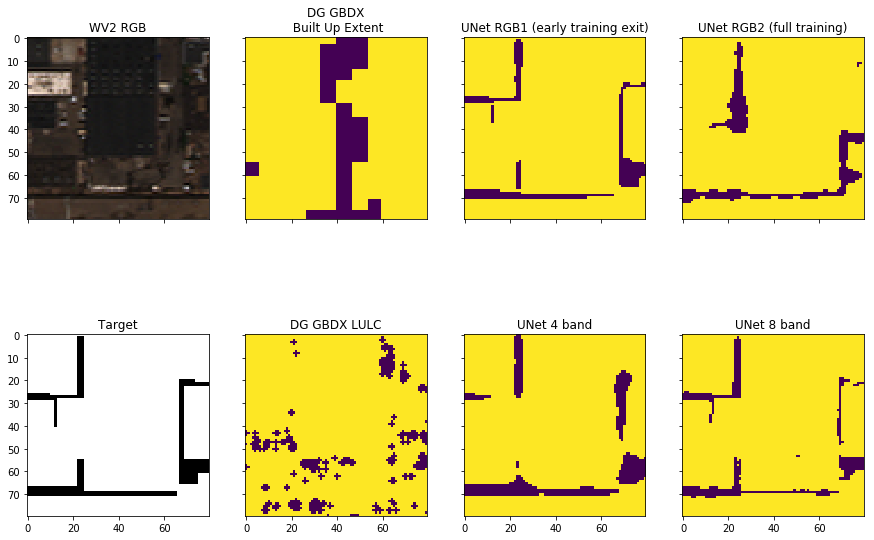

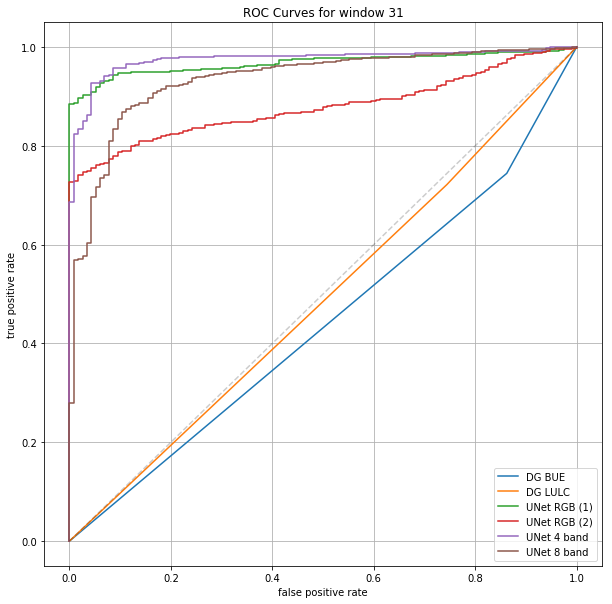

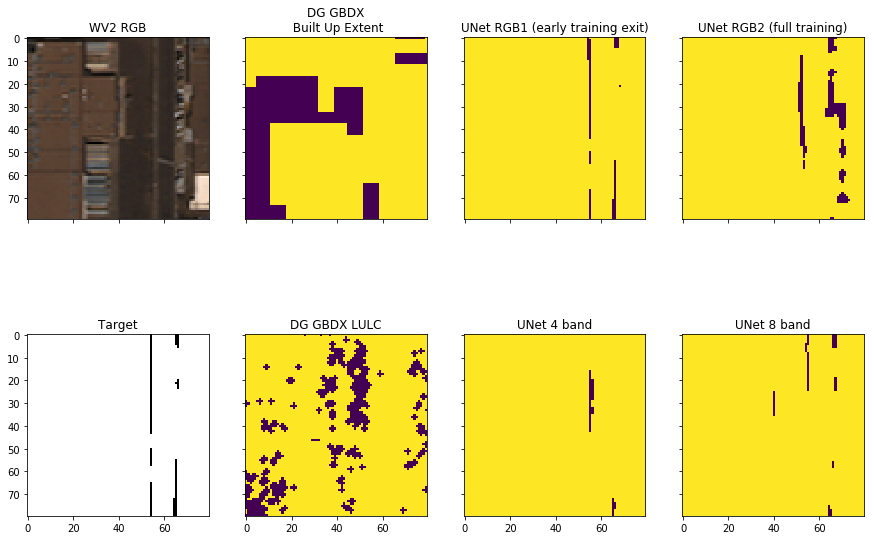

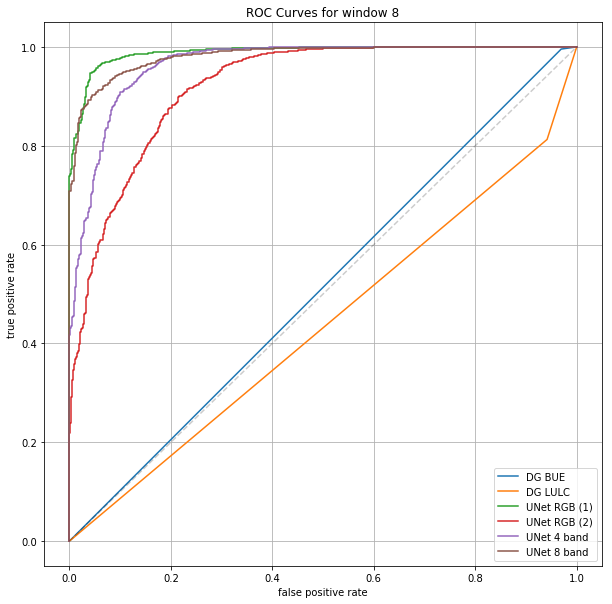

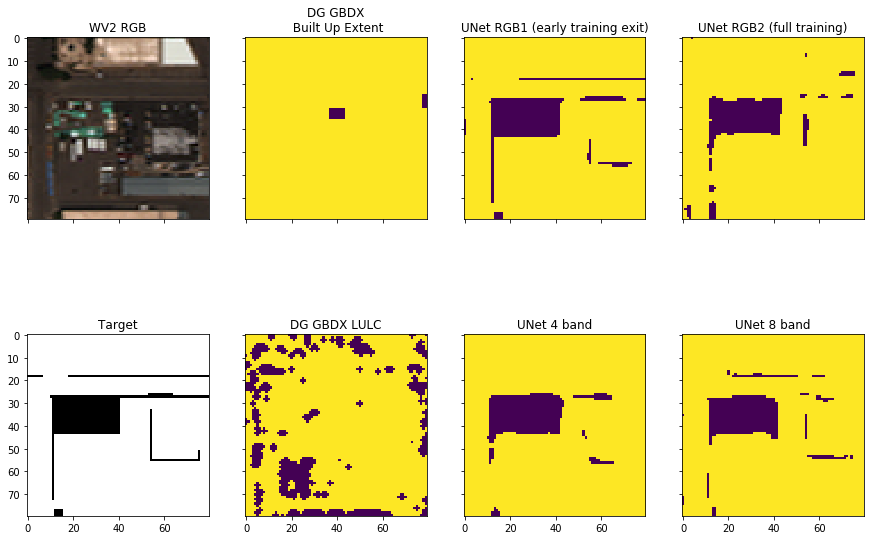

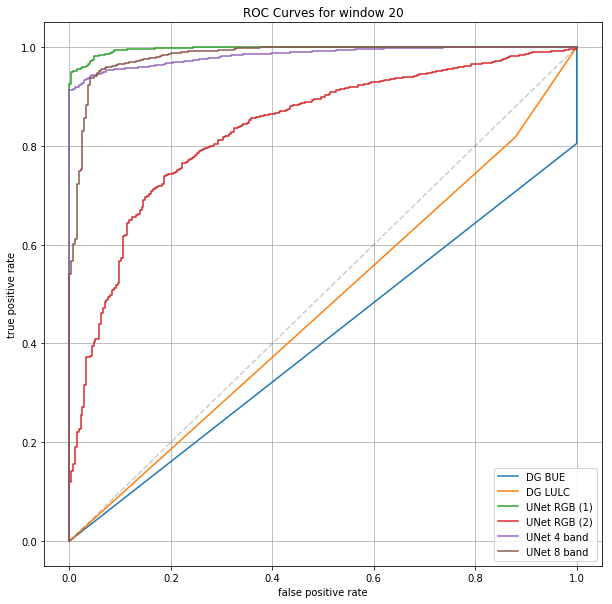

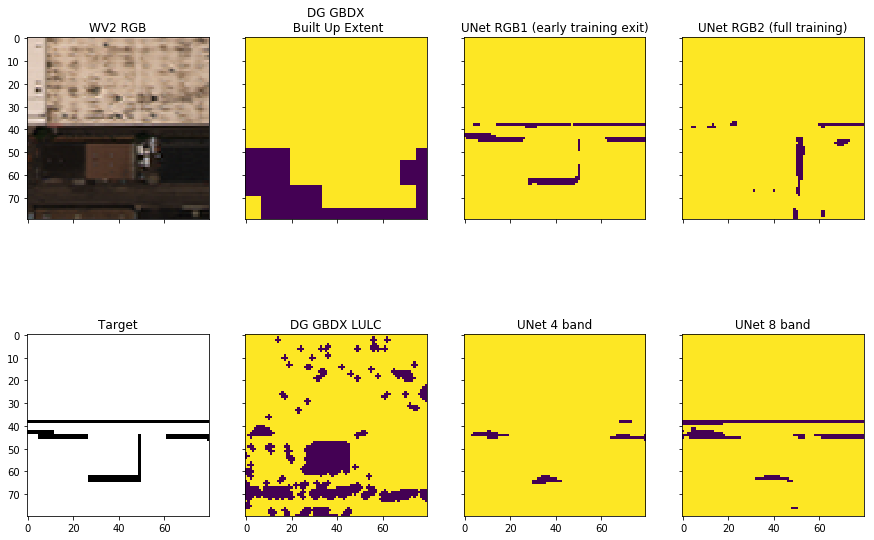

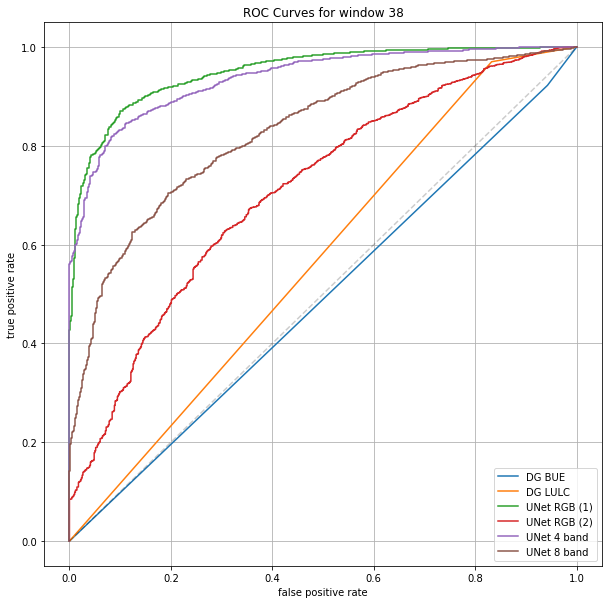

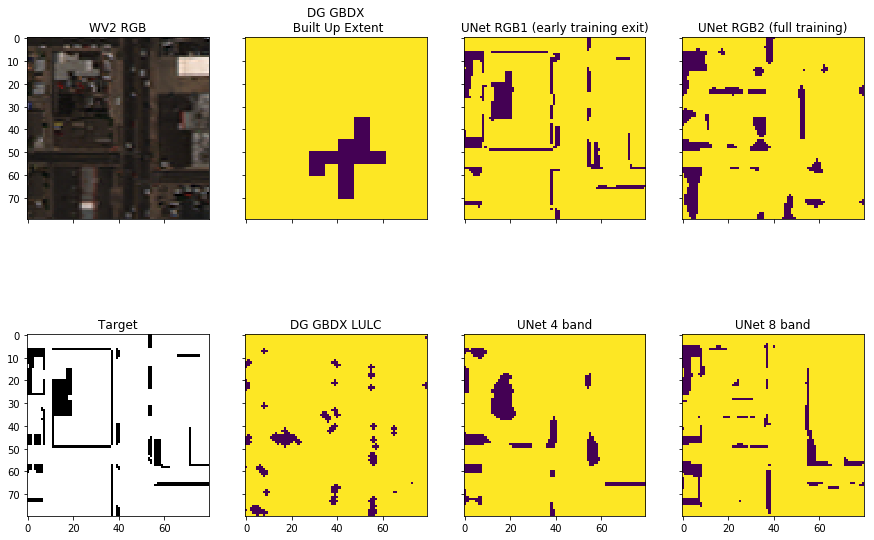

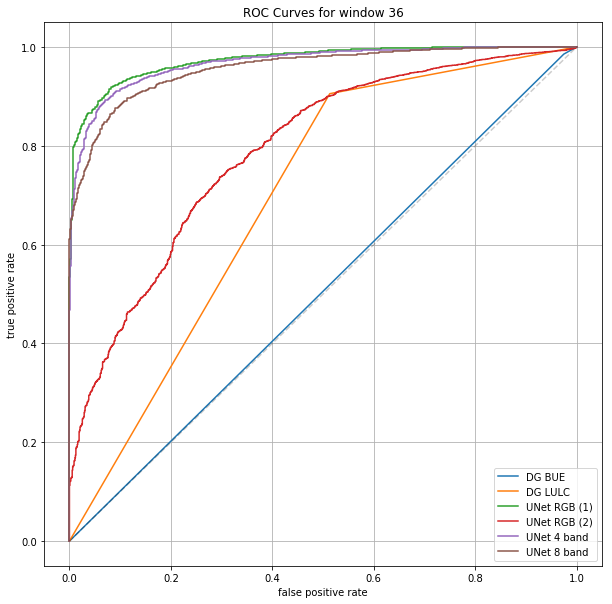

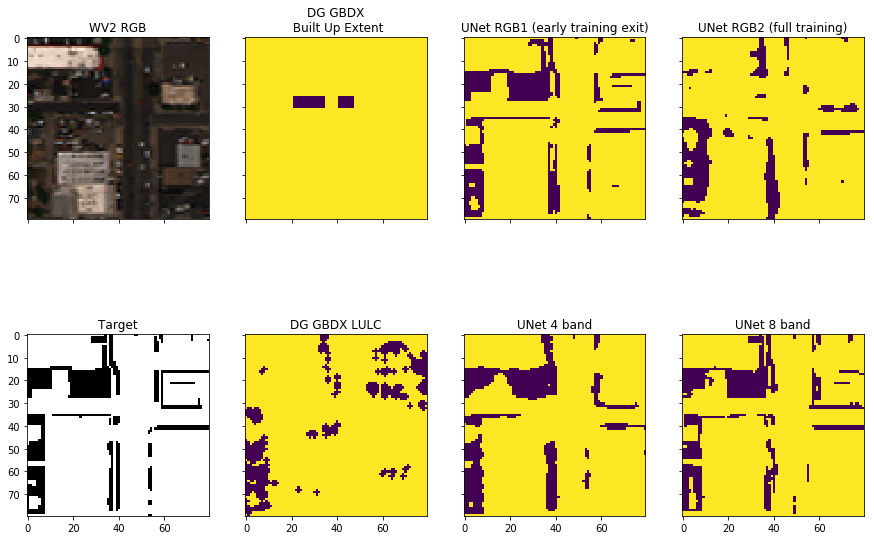

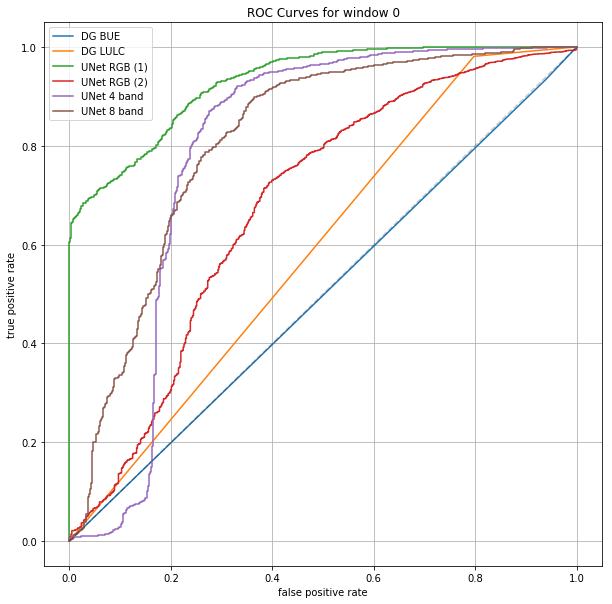

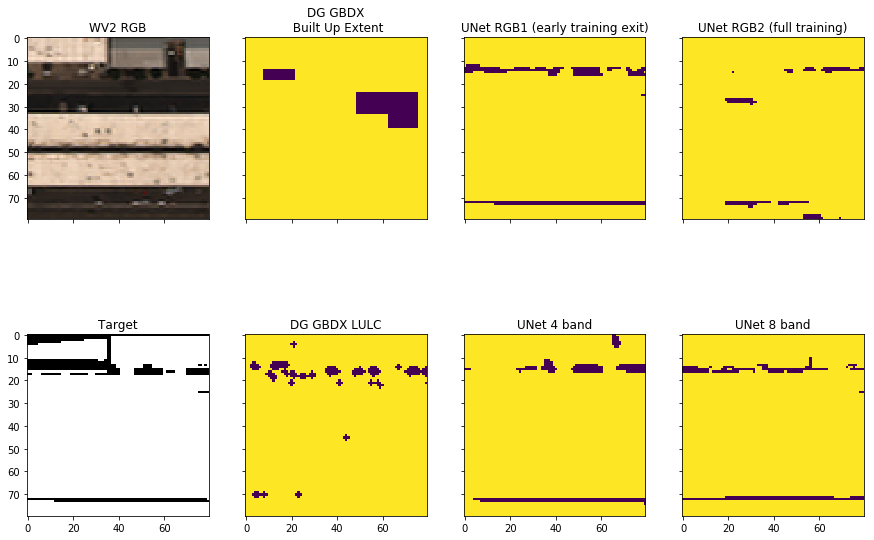

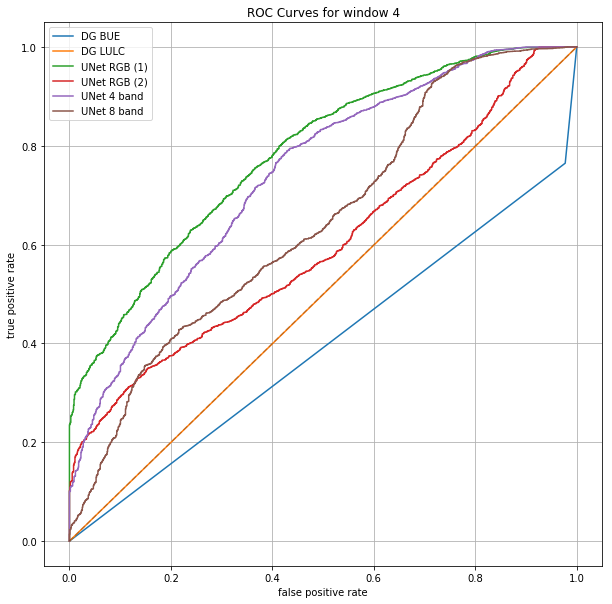

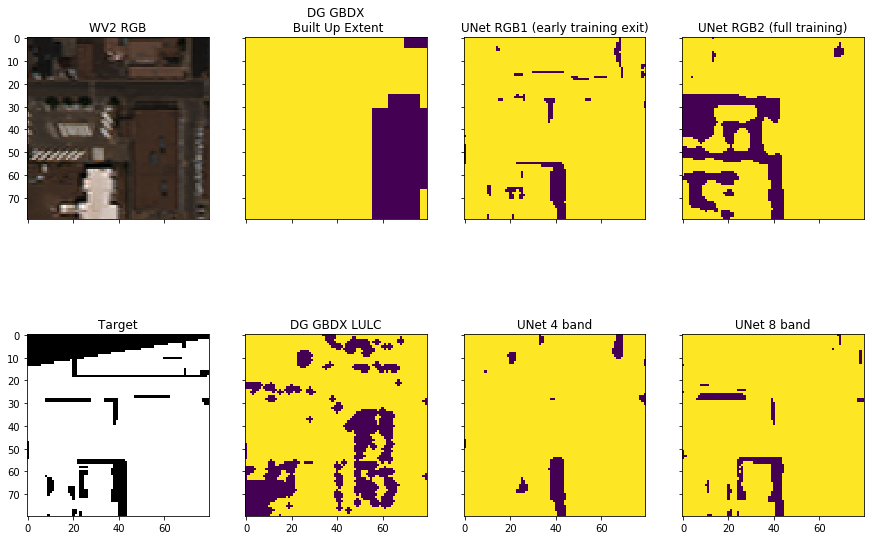

In [9]:
from scipy.misc import bytescale

# get the source image
dg_source_im = '../gbdx_outputs/055530875010_01_assembly.tif'
with rio.open(dg_source_im, 'r') as src:
    src_arr,_ = mask(src, [proc_aoi.__geo_interface__], crop=True, all_touched=False)

# flip the dimensions for plotting
src_arr = np.rollaxis(src_arr, 0, 3)

# pick a random sample for TPR vs FPR
np.random.seed(22)
for randind in np.random.choice(len(dg_bue_fpr), 42, replace=False):
    
    plt.figure(figsize=(10,10))
    plt.plot(dg_bue_fpr[randind], dg_bue_tpr[randind], label='DG BUE')
    plt.plot(dg_lulc_fpr[randind], dg_lulc_tpr[randind], label='DG LULC')
    plt.plot(unet_fpr_all[0][randind], unet_tpr_all[0][randind], label='UNet RGB (1)')
    plt.plot(unet_fpr_all[1][randind], unet_tpr_all[1][randind], label='UNet RGB (2)')
    plt.plot(unet_fpr_all[2][randind], unet_tpr_all[2][randind], label='UNet 4 band')
    plt.plot(unet_fpr_all[3][randind], unet_tpr_all[3][randind], label='UNet 8 band')
    plt.plot([0,1], '--k', alpha=0.2)
    plt.legend()
    plt.grid()
    plt.title('ROC Curves for window {}'.format(randind))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()
    
     # specify window coordinates (rows, cols)
    rmin = r[randind]
    rmax = rmin+winsize      
    cmin = c[randind]
    cmax = cmin+winsize
    
    # make a plot for the image arrays
    fig, ax = plt.subplots(2, 4, figsize=(15,10), sharex='col', sharey='row')
    
    # plot the RGB image (top left)
    ax[0,0].imshow(bytescale(src_arr[rmin:rmax, cmin:cmax, [4,2,1]]))
    ax[0,0].set_title('WV2 RGB')
    
    # plot the ground truth image (bottom left)
    ax[1,0].imshow(gt_arr[0, rmin:rmax, cmin:cmax], cmap='gray')
    ax[1,0].set_title('Target')

    # plot the DG images
    ax[0,1].imshow(dg_bue_arr[0, rmin:rmax, cmin:cmax])
    ax[0,1].set_title('DG GBDX\n Built Up Extent')
    ax[1,1].imshow(manmade[rmin:rmax, cmin:cmax])
    ax[1,1].set_title('DG GBDX LULC')

    # plot the UNet results
    with rio.open(im_UNet_RGB1) as src:
        arr = src.read(1)
        ax[0,2].imshow(arr[rmin:rmax, cmin:cmax] > 0)
        ax[0,2].set_title('UNet RGB1 (early training exit)')
        
    with rio.open(im_UNet_RGB2) as src:
        arr = src.read(1)
        ax[0,3].imshow(arr[rmin:rmax, cmin:cmax] > 0)
        ax[0,3].set_title('UNet RGB2 (full training)')
    
    with rio.open(im_UNet_4band) as src:
        arr = src.read(1)
        ax[1,2].imshow(arr[rmin:rmax, cmin:cmax] > 0)
        ax[1,2].set_title('UNet 4 band')
    
    with rio.open(im_UNet_8band) as src:
        arr = src.read(1)
        ax[1,3].imshow(arr[rmin:rmax, cmin:cmax] > 0)
        ax[1,3].set_title('UNet 8 band')   
    
    
    plt.show()

    

In [11]:
from gbdxtools import CatalogImage

ModuleNotFoundError: No module named 'gbdxtools'

In [ ]:
testid='1030010057062200'
shp_bounds = bnds
img_2m = CatalogImage(testid, band_type='MS', bbox=shp_bounds, acomp=True)
img_2m.shape

# construct the index and threshold
wi = (img_2m[0,:,:] - img_2m[7,:,:]) / (img_2m[0,:,:] + img_2m[7,:,:])
thresh = threshold_otsu(np.array(wi))
binary_w = wi > thresh

In [ ]:
# plot the BUI
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(bui, cmap=plt.cm.gray)
ax.set_title('Original BUI')
ax.axis('off')
colorbar(img)
plt.show()

# Plot the WI
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(wi, cmap=plt.cm.gray)
ax.set_title('Original WI')
ax.axis('off')
colorbar(img)
plt.show()

# plot the Otsu thresholded BUI
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(binary.astype('float32'), cmap=plt.cm.gray)
ax.set_title('Thresholded BUI (Otsu)')
ax.axis('off')
colorbar(img)
plt.show()

# plot the Otsu thresholded WI
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(binary_w.astype('float32'), cmap=plt.cm.gray)
ax.set_title('Thresholded WI (Otsu)')
ax.axis('off')
colorbar(img)
plt.show()

# plot the thresholded BUI but with WI=True pixels set to 0
binary_combo = binary.copy()
binary_combo[binary_w] = False
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(binary_combo.astype('float32'), cmap=plt.cm.gray)
ax.set_title('Thresholded BUI (Otsu), supress water mask')
ax.axis('off')
colorbar(img)
plt.show()


# look at histogram for WI
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(wi.ravel(), bins=256)
ax.set_title('Histogram WI')
ax.axvline(thresh, color='r')

plt.show()

# Otsu didn't do a good job, so manually set the threshold at 0.5 (ouch)
# plot the thresholded BUI but with WI=True pixels set to 0
binary_combo = binary.copy()
binary_w_man = wi > 0.5
binary_combo[binary_w_man] = False
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow(binary_combo.astype('float32'), cmap=plt.cm.gray)
ax.set_title('Thresholded BUI (Otsu), supress water mask (manual)')
ax.axis('off')
colorbar(img)
plt.show()

# plot the difference in masks
fig, ax = plt.subplots(figsize=(25, 20))
img = ax.imshow((np.array(binary_combo).astype('float32') - np.array(binary).astype('float32')), cmap=plt.cm.gray)
ax.set_title('Thresholded BUI (Otsu), supress water mask (manual)')
ax.axis('off')
colorbar(img)
plt.show()

# plot the manually thresholded water index
fig, ax = plt.subplots(figsize=(250,20))
img = ax.imshow(binary_w_man.astype('float32'), cmap=plt.cm.gray)
ax.set_title('Manually Thresholded WI')
ax.axis('off')
colorbar(img)
plt.show()